In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 1000
adam_lr = 1e-2
log_freq = 1

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 488


  0%|          | 0/1000 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0
Sharpe Ratio for the epoch: -0.2926
Average Weights:



,Weight
IRM,0.005214
JPM,0.004742
PTC,0.004542
ICE,0.004337
COST,0.004295
...,...
BBY,0.000916
TGT,0.000906
PODD,0.000902
ALB,0.000780


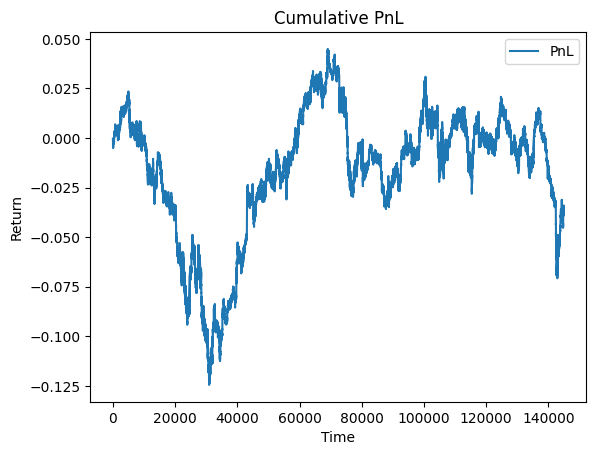

Sharpe Ratio for the epoch: 1.5892
Average Weights:



,Weight
IRM,0.012957
IBM,0.011433
PTC,0.011120
BKNG,0.009877
IP,0.009091
...,...
BBY,0.000433
ROST,0.000420
TGT,0.000393
ALB,0.000311


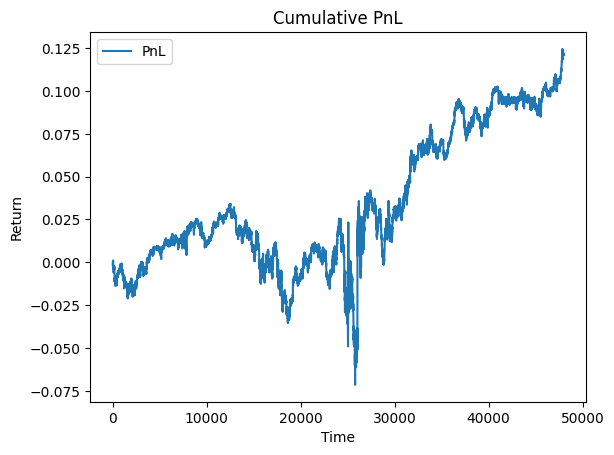

  0%|          | 1/1000 [01:01<16:59:47, 61.25s/it]

Sharpe Ratio for the epoch: 1.3953
Average Weights:



,Weight
IRM,0.078362
GRMN,0.076828
JPM,0.070318
PTC,0.038665
IBM,0.034592
...,...
DG,0.000079
ROST,0.000079
TGT,0.000075
ALB,0.000049


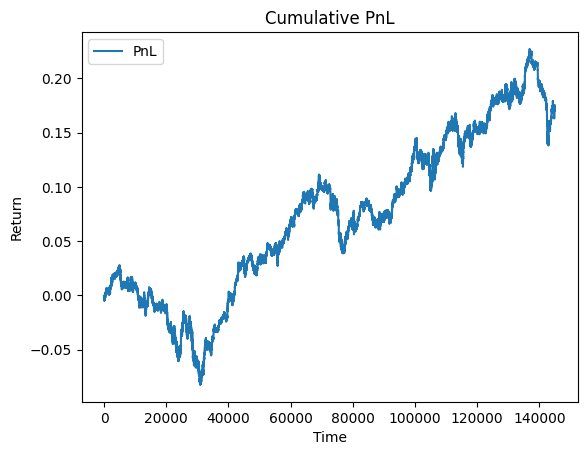

Sharpe Ratio for the epoch: 2.4018
Average Weights:



,Weight
IP,1.304306e-01
GRMN,1.266881e-01
IRM,1.232286e-01
IBM,9.000590e-02
BKNG,6.926113e-02
...,...
BBY,1.288644e-05
ROST,1.190668e-05
TGT,1.084281e-05
ALB,7.500071e-06


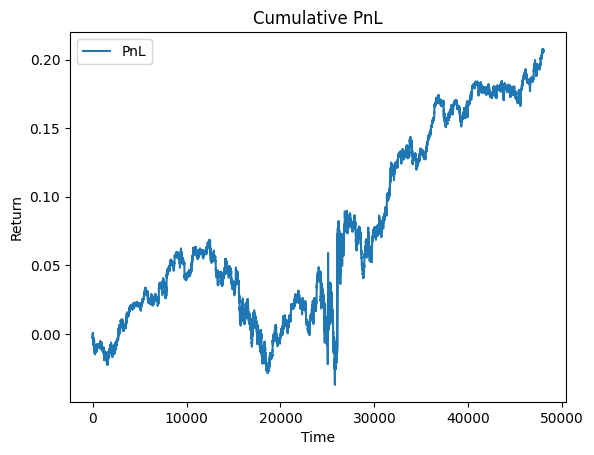

  0%|          | 2/1000 [01:52<15:21:57, 55.43s/it]

Sharpe Ratio for the epoch: 2.5897
Average Weights:



,Weight
GRMN,0.128478
IRM,0.126235
IBM,0.084644
BKNG,0.081503
IP,0.077020
...,...
BBY,0.000017
ROST,0.000017
TGT,0.000015
ALB,0.000010


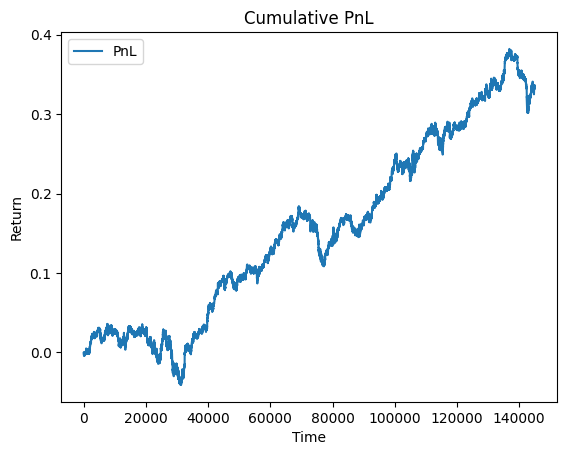

Sharpe Ratio for the epoch: 2.2910
Average Weights:



,Weight
IP,2.428187e-01
IBM,1.065709e-01
GRMN,9.281296e-02
IRM,8.687162e-02
FFIV,6.717876e-02
...,...
ROST,6.809805e-06
BBY,6.755949e-06
TGT,6.039381e-06
ALB,4.519396e-06


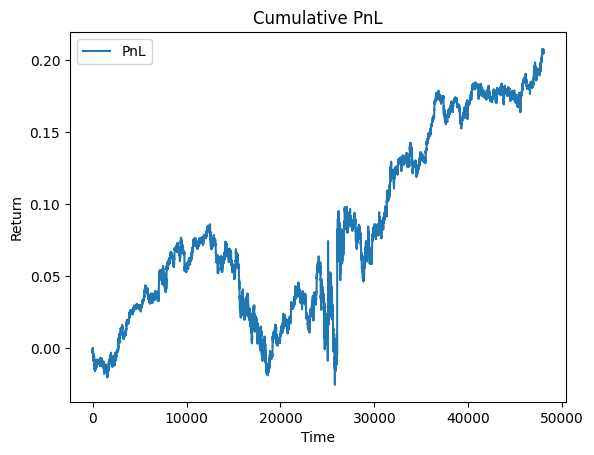

  0%|          | 3/1000 [02:42<14:37:26, 52.81s/it]

Sharpe Ratio for the epoch: 2.7012
Average Weights:



,Weight
GRMN,0.118845
IBM,0.101802
IRM,0.097488
IP,0.096599
BKNG,0.073081
...,...
BBY,0.000014
ROST,0.000014
TGT,0.000012
ALB,0.000009


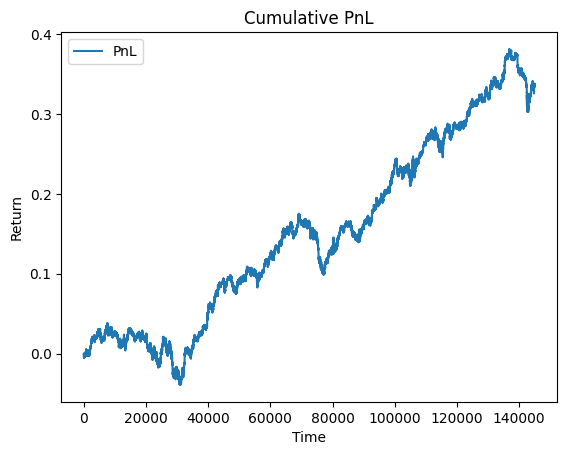

Sharpe Ratio for the epoch: 2.5044
Average Weights:



,Weight
IP,1.564224e-01
IBM,1.156413e-01
BKNG,9.928646e-02
FFIV,9.905339e-02
GRMN,9.520451e-02
...,...
BBY,5.274033e-06
ROST,5.176762e-06
TGT,4.618850e-06
ALB,3.635735e-06


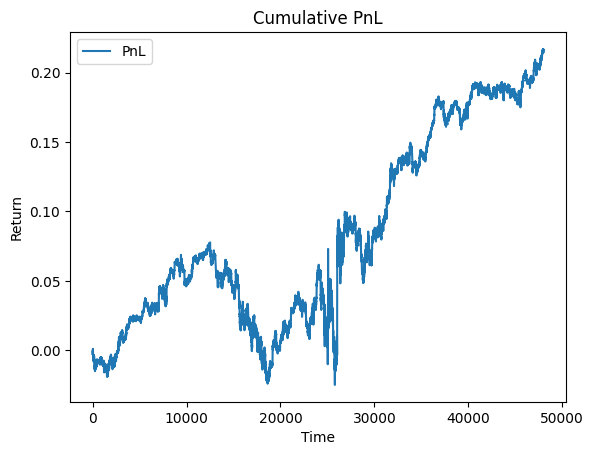

  0%|          | 4/1000 [03:32<14:19:07, 51.75s/it]

Sharpe Ratio for the epoch: 2.8386
Average Weights:



,Weight
GRMN,0.111407
IBM,0.106532
BKNG,0.089014
IRM,0.084666
IP,0.084469
...,...
BBY,0.000013
ROST,0.000013
TGT,0.000011
ALB,0.000008


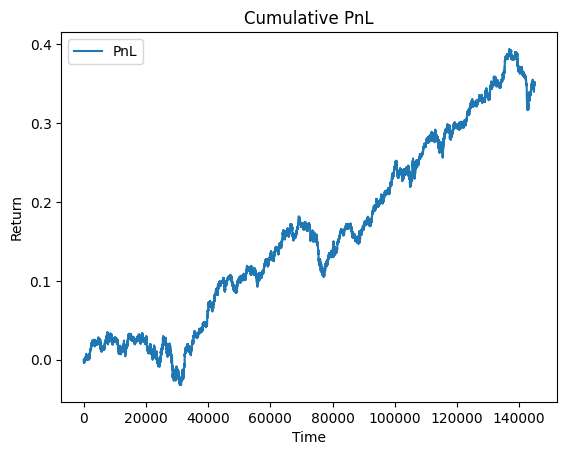

Sharpe Ratio for the epoch: 2.5472
Average Weights:



,Weight
IP,1.390542e-01
IBM,1.227773e-01
FFIV,1.070637e-01
GRMN,9.603340e-02
BKNG,9.064389e-02
...,...
BBY,4.625220e-06
ROST,4.420576e-06
TGT,3.973544e-06
ALB,3.260520e-06


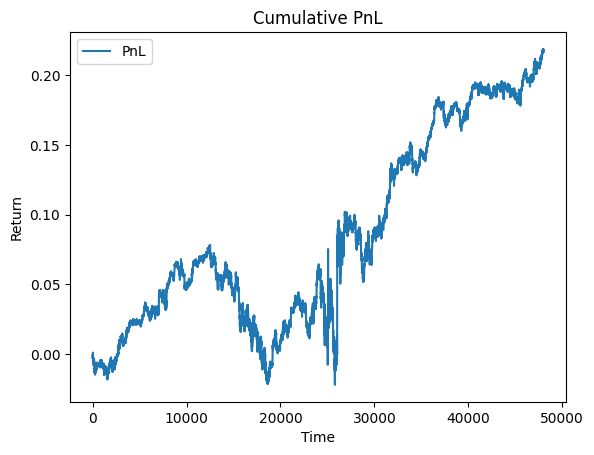

  0%|          | 5/1000 [04:22<14:08:48, 51.18s/it]

Sharpe Ratio for the epoch: 2.9274
Average Weights:



,Weight
GRMN,0.111753
IBM,0.109440
FFIV,0.088438
BKNG,0.082747
IP,0.080996
...,...
BBY,0.000011
ROST,0.000010
TGT,0.000009
ALB,0.000007


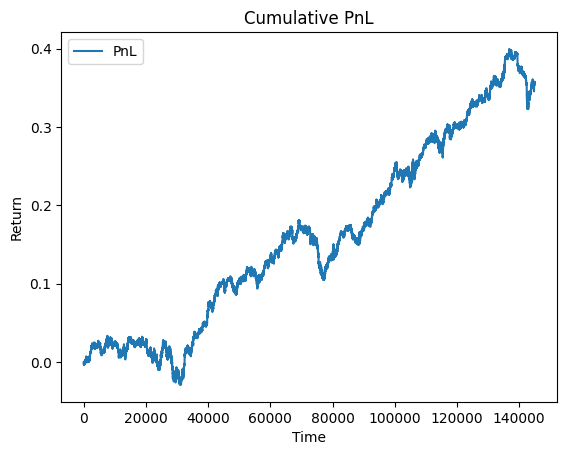

Sharpe Ratio for the epoch: 2.5656
Average Weights:



,Weight
IP,1.271030e-01
IBM,1.142908e-01
FFIV,1.015038e-01
GRMN,9.832136e-02
BKNG,9.108757e-02
...,...
BBY,4.551811e-06
ROST,4.204649e-06
TGT,3.827082e-06
ALB,3.227647e-06


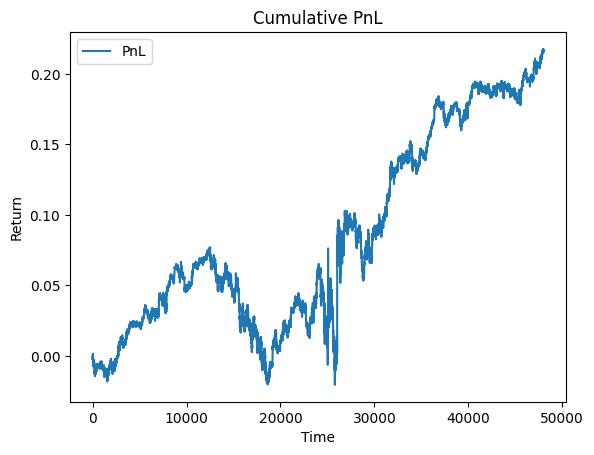

  1%|          | 6/1000 [05:12<14:02:49, 50.87s/it]

Sharpe Ratio for the epoch: 2.9838
Average Weights:



,Weight
GRMN,0.112048
IBM,0.103491
FFIV,0.087926
BKNG,0.082162
IRM,0.079404
...,...
DOW,0.000009
ROST,0.000009
TGT,0.000008
ALB,0.000006


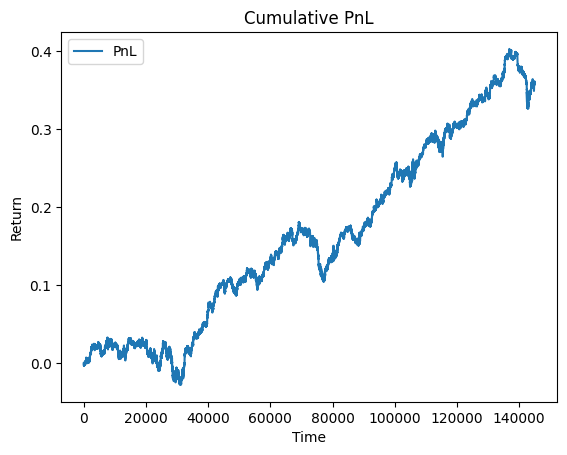

Sharpe Ratio for the epoch: 2.5768
Average Weights:



,Weight
IP,0.117953
IBM,0.105776
GRMN,0.100700
FFIV,0.096080
BKNG,0.085897
...,...
DOW,0.000005
ROST,0.000004
TGT,0.000004
ALB,0.000003


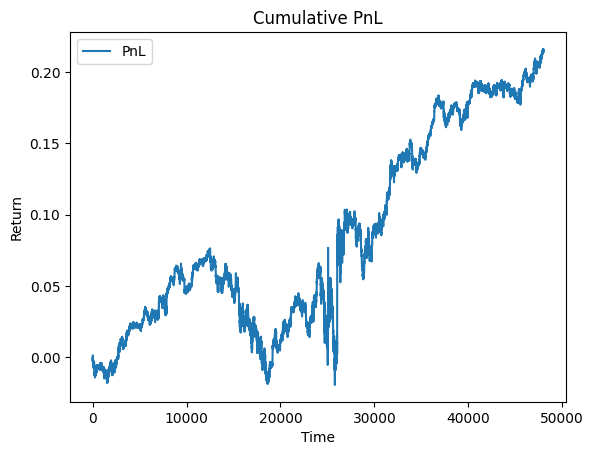

  1%|          | 7/1000 [06:03<13:59:22, 50.72s/it]

Sharpe Ratio for the epoch: 3.0344
Average Weights:



,Weight
GRMN,0.112112
IBM,0.097505
FFIV,0.086108
BKNG,0.079381
IRM,0.078679
...,...
DOW,0.000008
ROST,0.000008
TGT,0.000007
ALB,0.000006


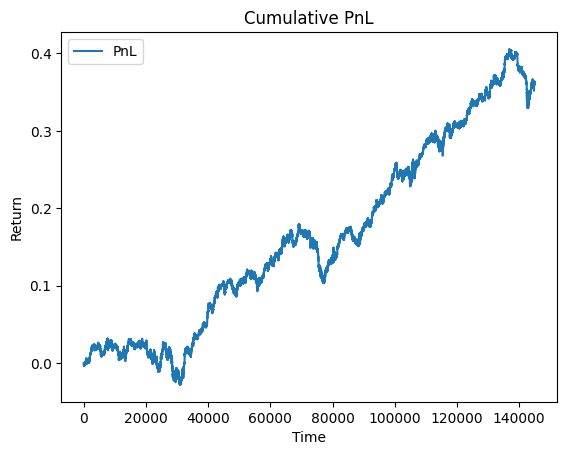

Sharpe Ratio for the epoch: 2.5936
Average Weights:



,Weight
IP,0.112634
GRMN,0.103232
IBM,0.098017
FFIV,0.089068
BKNG,0.081505
...,...
DOW,0.000004
ROST,0.000004
TGT,0.000004
ALB,0.000003


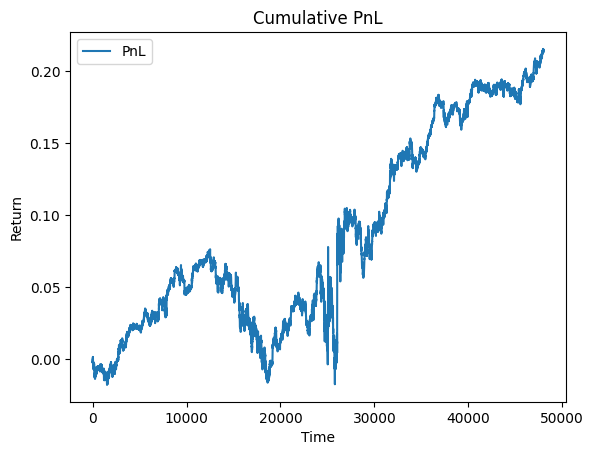

  1%|          | 8/1000 [06:53<13:55:34, 50.54s/it]

Sharpe Ratio for the epoch: 3.0799
Average Weights:



,Weight
GRMN,0.111839
IBM,0.092059
FFIV,0.083687
BKNG,0.077760
IRM,0.077624
...,...
DOW,0.000007
ROST,0.000007
TGT,0.000006
ALB,0.000006


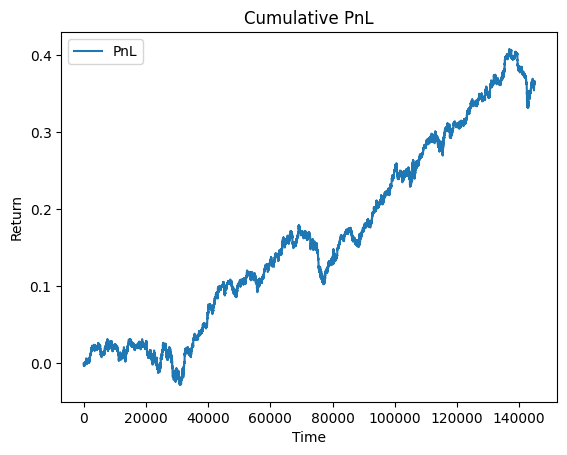

Sharpe Ratio for the epoch: 2.6176
Average Weights:



,Weight
IP,0.110229
GRMN,0.102992
IBM,0.092756
FFIV,0.085362
BKNG,0.080525
...,...
DOW,0.000004
ROST,0.000004
TGT,0.000003
ALB,0.000003


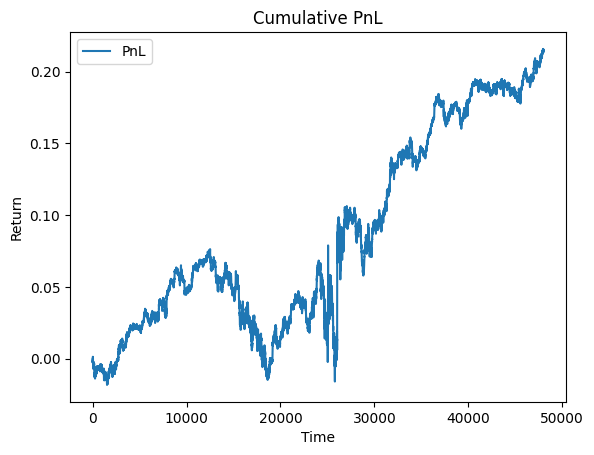

  1%|          | 9/1000 [07:42<13:48:21, 50.15s/it]

Sharpe Ratio for the epoch: 3.1142
Average Weights:



,Weight
GRMN,0.111370
IBM,0.088438
FFIV,0.082584
BKNG,0.077815
IRM,0.076881
...,...
DOW,0.000007
ROST,0.000007
TGT,0.000006
ALB,0.000005


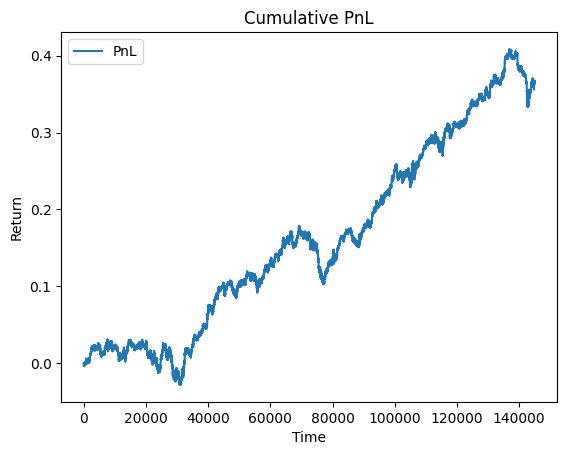

Sharpe Ratio for the epoch: 2.6437
Average Weights:



,Weight
IP,0.106235
GRMN,0.101508
IBM,0.091572
FFIV,0.086307
BKNG,0.083119
...,...
DOW,0.000003
ROST,0.000003
TGT,0.000003
Cash,0.000003


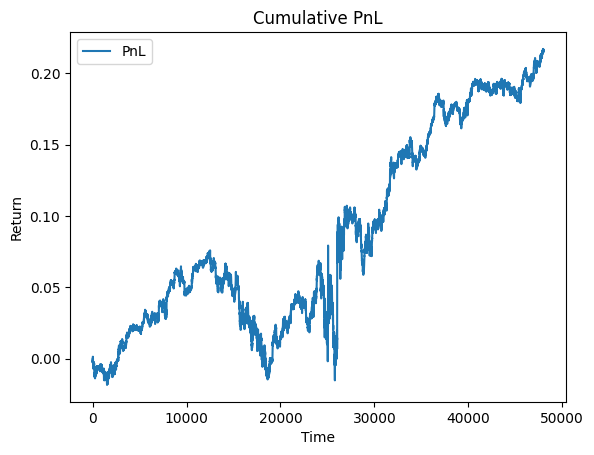

  1%|          | 10/1000 [08:31<13:42:14, 49.83s/it]

Sharpe Ratio for the epoch: 3.1450
Average Weights:



,Weight
GRMN,0.110077
IBM,0.087191
FFIV,0.083072
BKNG,0.078768
IP,0.076375
...,...
Cash,0.000007
DOW,0.000007
ROST,0.000006
TGT,0.000006


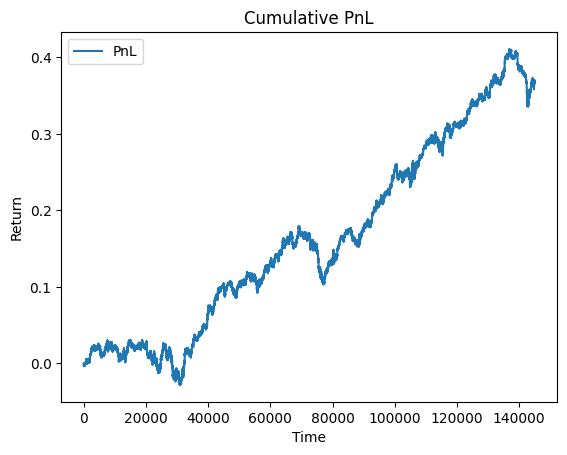

Sharpe Ratio for the epoch: 2.6468
Average Weights:



,Weight
IP,0.104160
GRMN,0.101838
IBM,0.089312
FFIV,0.086399
BKNG,0.082399
...,...
TEL,0.000003
DOW,0.000003
ROST,0.000003
TGT,0.000003


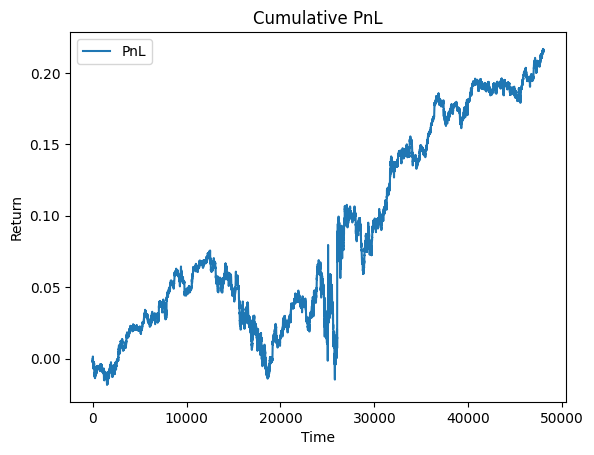

  1%|          | 11/1000 [09:20<13:35:13, 49.46s/it]

Sharpe Ratio for the epoch: 3.1794
Average Weights:



,Weight
GRMN,0.110586
IBM,0.085899
FFIV,0.083124
BKNG,0.078426
IRM,0.076776
...,...
TEL,0.000006
DOW,0.000006
ROST,0.000006
TGT,0.000005


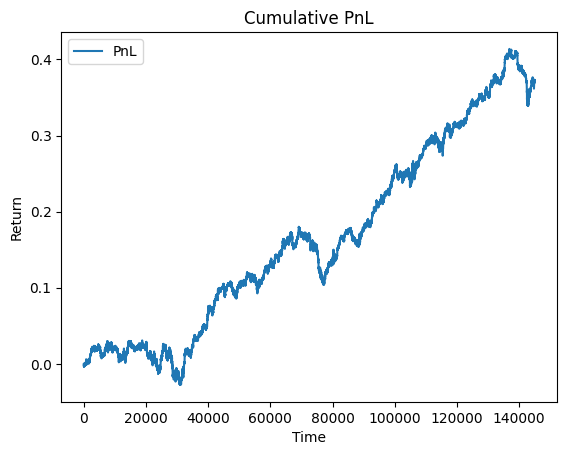

Sharpe Ratio for the epoch: 2.6427
Average Weights:



,Weight
IP,0.105668
GRMN,0.096649
FFIV,0.085055
IBM,0.084276
BKNG,0.083899
...,...
TEL,0.000004
DOW,0.000003
ROST,0.000003
TGT,0.000003


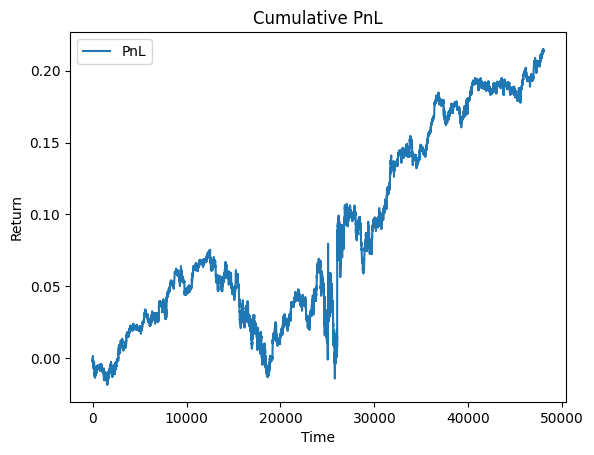

  1%|          | 12/1000 [10:09<13:30:39, 49.23s/it]

Sharpe Ratio for the epoch: 3.2032
Average Weights:



,Weight
GRMN,0.111439
IBM,0.081941
FFIV,0.081455
IRM,0.079212
BKNG,0.078013
...,...
TEL,0.000005
DOW,0.000005
ROST,0.000005
TGT,0.000004


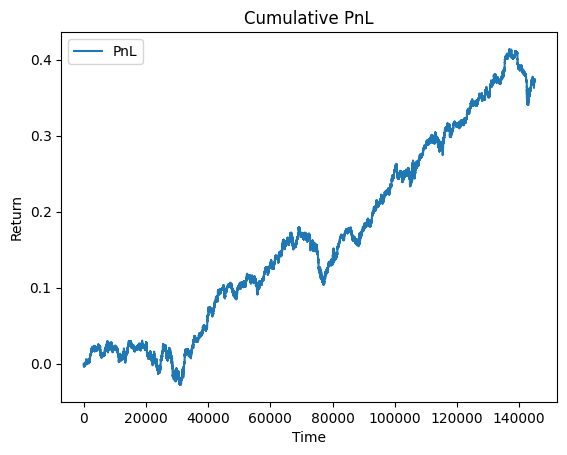

Sharpe Ratio for the epoch: 2.6571
Average Weights:



,Weight
IP,0.101684
GRMN,0.090675
FFIV,0.085312
BKNG,0.084566
IBM,0.081861
...,...
TEL,0.000005
DOW,0.000004
ROST,0.000004
ALB,0.000004


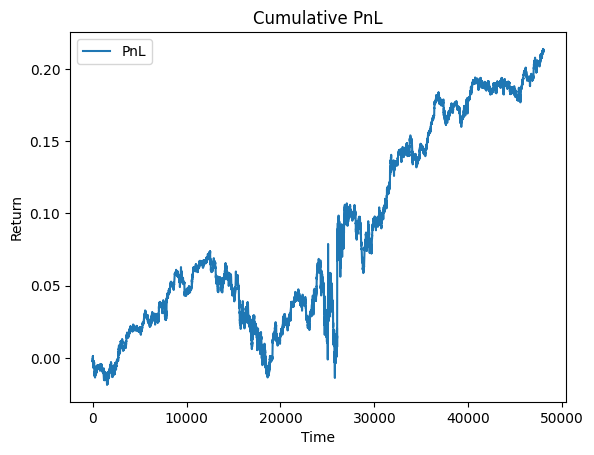

  1%|▏         | 13/1000 [10:58<13:28:44, 49.16s/it]

Sharpe Ratio for the epoch: 3.2434
Average Weights:



,Weight
GRMN,0.104809
FFIV,0.081301
IBM,0.079301
IRM,0.079199
BKNG,0.077754
...,...
TEL,0.000004
DOW,0.000004
ROST,0.000004
TGT,0.000004


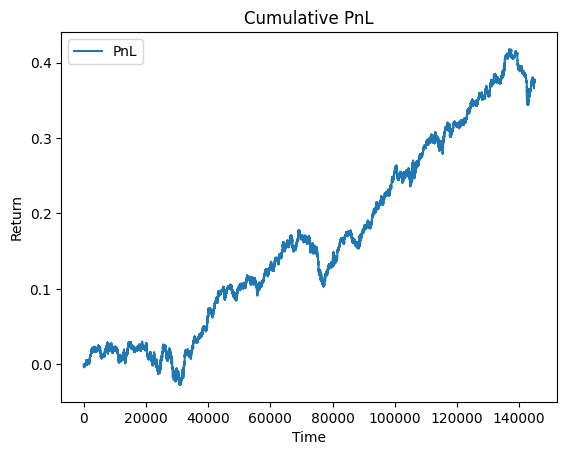

Sharpe Ratio for the epoch: 2.6940
Average Weights:



,Weight
IP,0.103678
GRMN,0.089536
FFIV,0.078766
IBM,0.078514
BKNG,0.075449
...,...
TEL,0.000005
ROST,0.000004
DOW,0.000004
ALB,0.000004


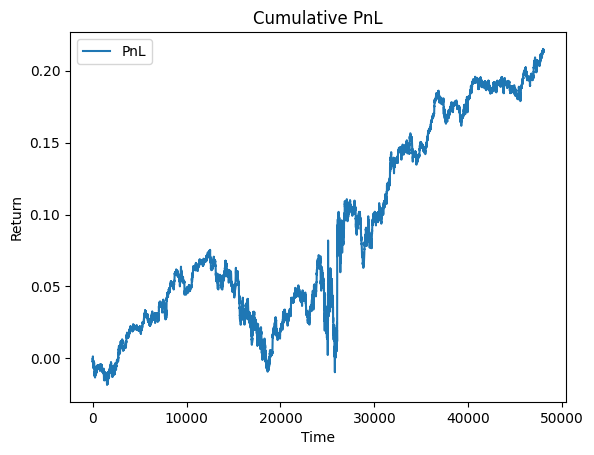

  1%|▏         | 14/1000 [11:47<13:26:48, 49.10s/it]

Sharpe Ratio for the epoch: 3.2870
Average Weights:



,Weight
GRMN,0.100915
FFIV,0.078892
IBM,0.077753
IP,0.077360
BKNG,0.075395
...,...
TEL,0.000005
DOW,0.000005
ROST,0.000005
TGT,0.000004


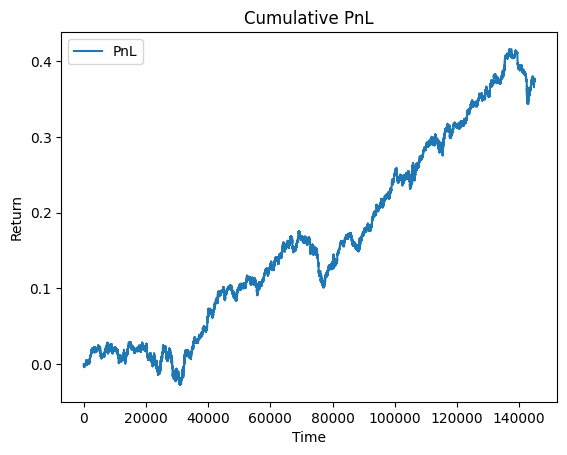

Sharpe Ratio for the epoch: 2.8358
Average Weights:



,Weight
IP,0.107152
BKNG,0.085483
GRMN,0.084494
IBM,0.082489
FFIV,0.081286
...,...
TEL,0.000003
DOW,0.000003
ROST,0.000003
TGT,0.000003


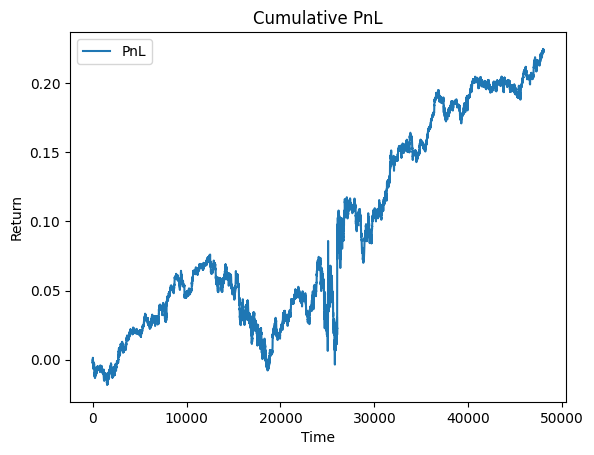

  2%|▏         | 15/1000 [12:36<13:27:37, 49.20s/it]

Sharpe Ratio for the epoch: 3.3292
Average Weights:



,Weight
GRMN,0.098123
BKNG,0.081359
FFIV,0.078928
IBM,0.078593
IP,0.074891
...,...
TEL,0.000006
ROST,0.000005
DOW,0.000005
ALB,0.000005


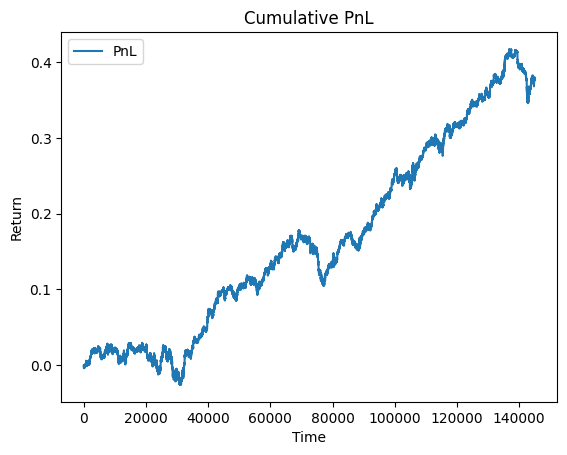

Sharpe Ratio for the epoch: 3.1280
Average Weights:



,Weight
IP,0.094821
BKNG,0.094081
IBM,0.091176
FFIV,0.090417
GRMN,0.086821
...,...
TEL,0.000002
DOW,0.000002
ROST,0.000002
TGT,0.000002


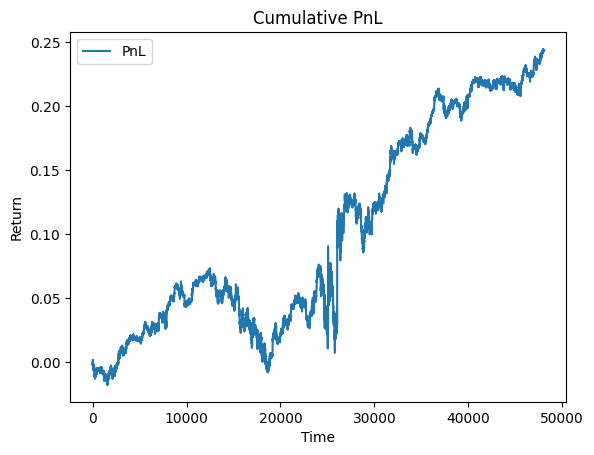

  2%|▏         | 16/1000 [13:25<13:27:39, 49.25s/it]

Sharpe Ratio for the epoch: 3.4856
Average Weights:



,Weight
GRMN,0.093105
BKNG,0.087426
IBM,0.083243
FFIV,0.081924
IP,0.071258
...,...
TEL,0.000005
ROST,0.000005
DOW,0.000005
ALB,0.000004


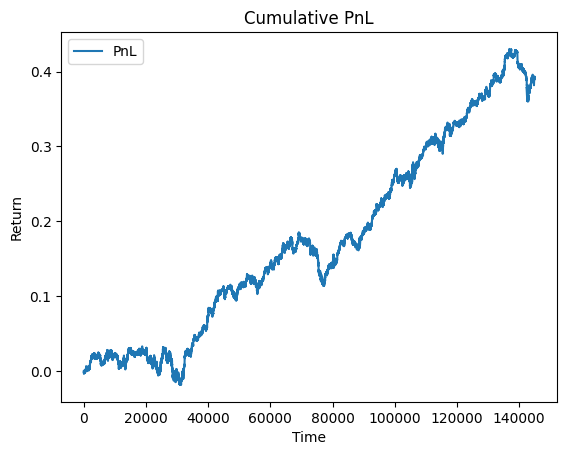

Sharpe Ratio for the epoch: 3.7722
Average Weights:



,Weight
BKNG,0.097970
IP,0.089577
GRMN,0.089284
IBM,0.085073
FFIV,0.082102
...,...
TEL,0.000002
DOW,0.000001
ROST,0.000001
ALB,0.000001


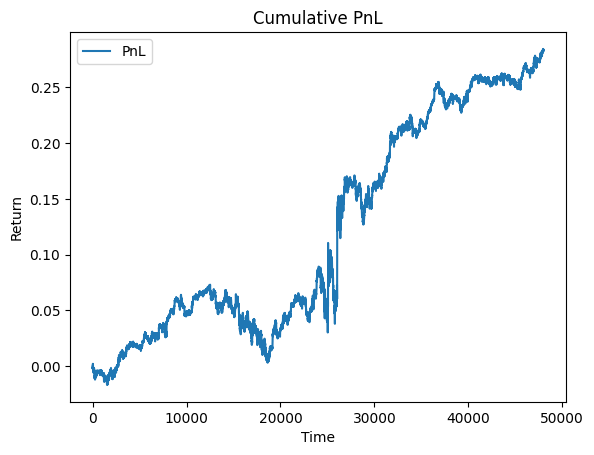

  2%|▏         | 17/1000 [14:15<13:26:42, 49.24s/it]

Sharpe Ratio for the epoch: 3.9812
Average Weights:



,Weight
Cash,0.096826
BKNG,0.094615
GRMN,0.090967
IBM,0.078641
FFIV,0.075522
...,...
TEL,0.000003
DOW,0.000003
ROST,0.000003
TGT,0.000003


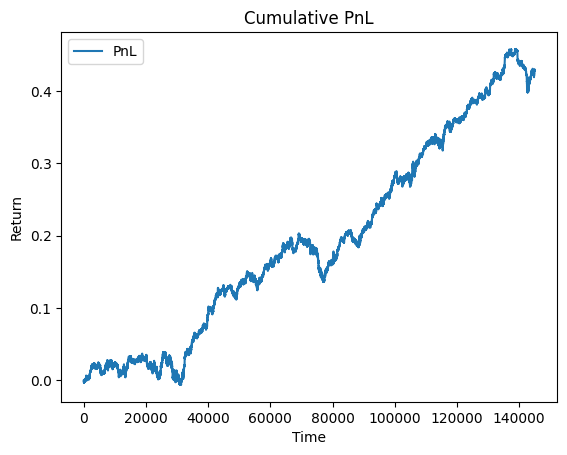

Sharpe Ratio for the epoch: 6.3930
Average Weights:



,Weight
Cash,1.928325e-01
BKNG,1.395186e-01
FICO,7.031582e-02
GRMN,6.830103e-02
IBM,6.737103e-02
...,...
TEL,8.966398e-07
DOW,8.231416e-07
ROST,8.191228e-07
ALB,7.935031e-07


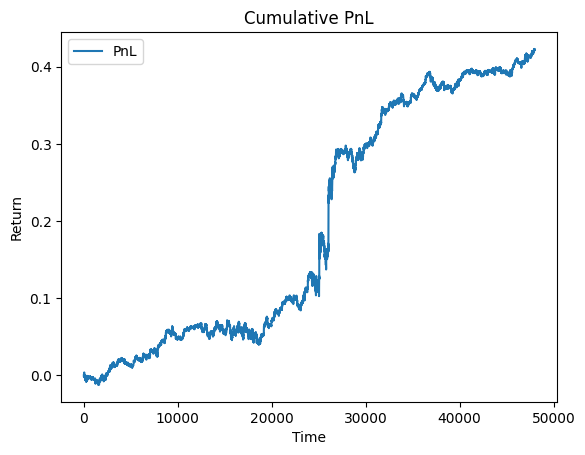

  2%|▏         | 18/1000 [15:04<13:25:55, 49.24s/it]

Sharpe Ratio for the epoch: 7.7232
Average Weights:



,Weight
Cash,7.451367e-01
BKNG,8.265236e-02
FICO,6.751148e-02
IBM,1.365261e-02
FFIV,1.338770e-02
...,...
TEL,8.527599e-08
ROST,7.755889e-08
DOW,7.742563e-08
ALB,7.534797e-08


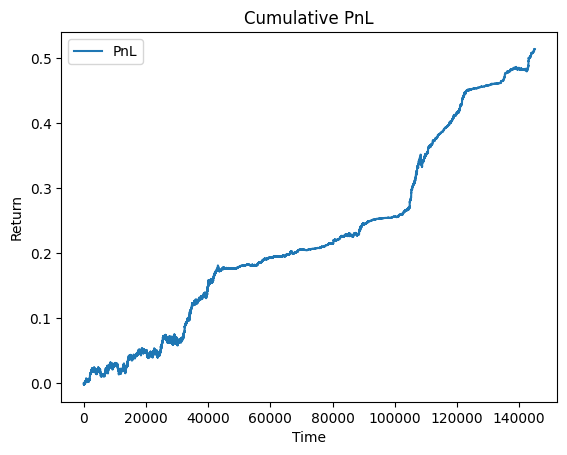

Sharpe Ratio for the epoch: 20.9908
Average Weights:



,Weight
Cash,8.909971e-01
BKNG,6.902716e-02
FICO,3.867164e-02
FFIV,2.515175e-04
GRMN,2.330392e-04
...,...
PPG,7.880478e-12
ROST,7.005163e-12
TGT,6.685733e-12
DOW,6.582420e-12


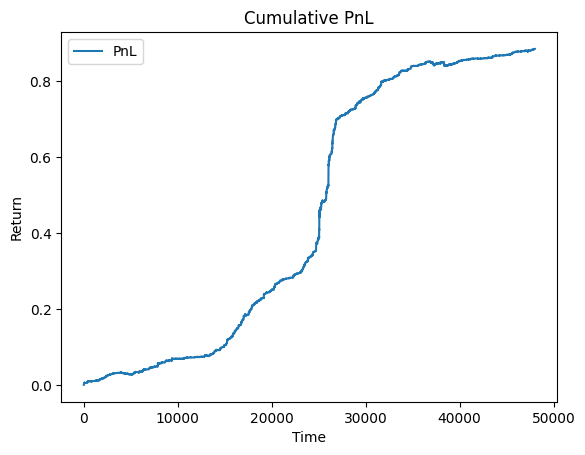

  2%|▏         | 19/1000 [15:53<13:26:03, 49.30s/it]

Sharpe Ratio for the epoch: 16.8584
Average Weights:



,Weight
Cash,8.331941e-01
BKNG,1.076933e-01
FICO,5.838910e-02
FFIV,1.353230e-04
GRMN,1.181090e-04
...,...
PPG,5.610447e-12
ROST,4.950788e-12
TGT,4.730231e-12
ALB,4.552856e-12


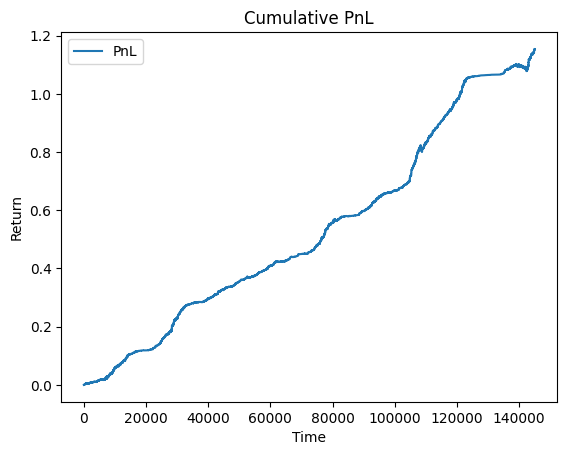

Sharpe Ratio for the epoch: 26.4644
Average Weights:



,Weight
Cash,6.682239e-01
BKNG,1.817826e-01
FICO,1.486531e-01
FFIV,2.245950e-04
GRMN,1.880794e-04
...,...
PPG,2.669957e-11
ROST,2.329179e-11
TGT,2.252257e-11
ALB,2.177741e-11


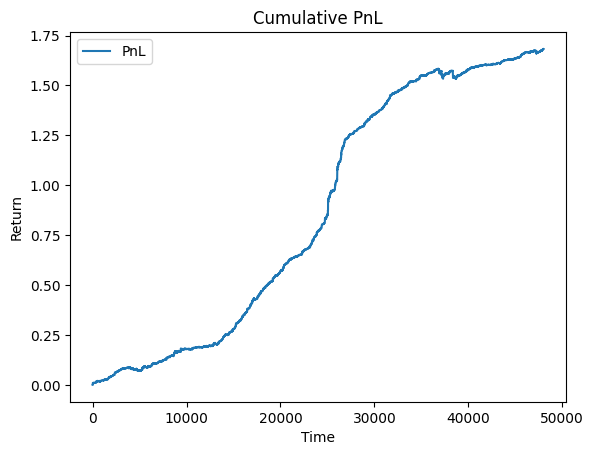

  2%|▏         | 20/1000 [16:43<13:26:14, 49.36s/it]

Sharpe Ratio for the epoch: 20.5080
Average Weights:



,Weight
Cash,8.013297e-01
BKNG,1.318912e-01
FICO,6.617899e-02
FFIV,9.597533e-05
GRMN,7.935822e-05
...,...
PPG,1.188016e-11
ROST,1.029211e-11
TGT,1.001110e-11
ALB,9.754393e-12


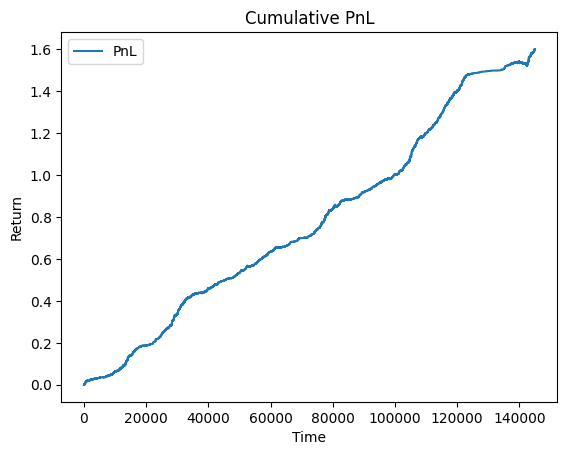

Sharpe Ratio for the epoch: 27.1346
Average Weights:



,Weight
Cash,6.078877e-01
BKNG,2.207979e-01
FICO,1.701844e-01
FFIV,1.556922e-04
GRMN,1.268991e-04
...,...
TEL,4.974184e-11
ROST,4.316303e-11
TGT,4.229508e-11
ALB,4.133340e-11


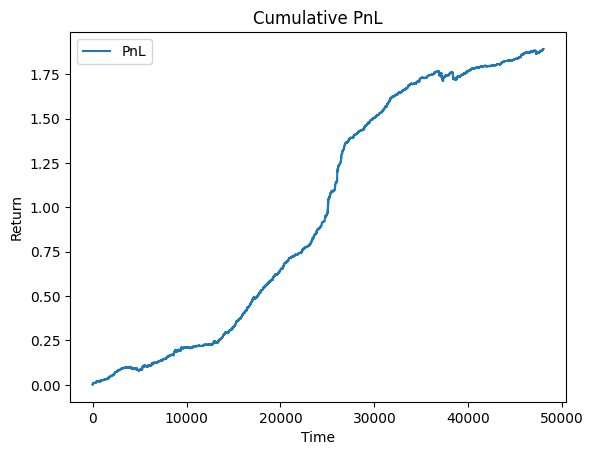

  2%|▏         | 21/1000 [17:32<13:23:17, 49.23s/it]

Sharpe Ratio for the epoch: 23.4029
Average Weights:



,Weight
Cash,7.789708e-01
BKNG,1.279203e-01
FICO,6.478824e-02
NVR,2.777133e-02
FFIV,8.070478e-05
...,...
TEL,3.000757e-11
ROST,2.581245e-11
TGT,2.554182e-11
ALB,2.527970e-11


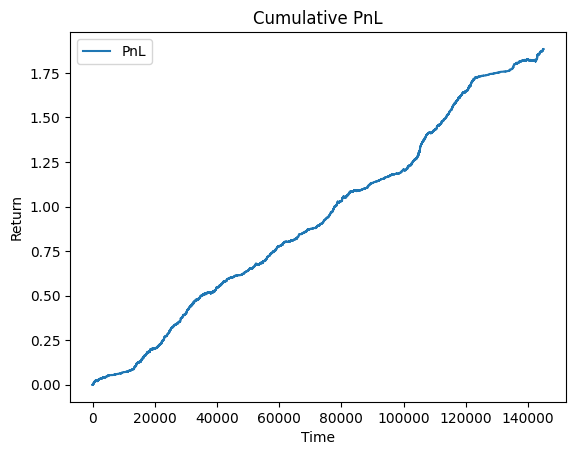

Sharpe Ratio for the epoch: 29.0275
Average Weights:



,Weight
Cash,7.644004e-01
BKNG,1.399655e-01
FICO,8.850160e-02
NVR,6.546775e-03
FFIV,8.324206e-05
...,...
TEL,3.782227e-11
ROST,3.242094e-11
ALB,3.193120e-11
TGT,3.189527e-11


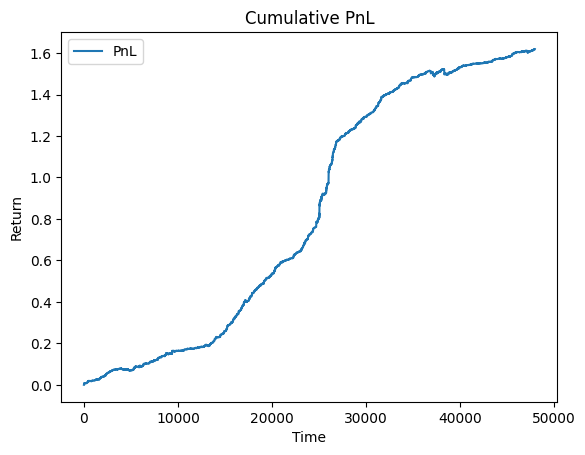

  2%|▏         | 22/1000 [18:21<13:21:21, 49.16s/it]

Sharpe Ratio for the epoch: 25.7490
Average Weights:



,Weight
Cash,7.706712e-01
BKNG,1.232204e-01
FICO,6.190199e-02
NVR,4.360887e-02
FFIV,7.414740e-05
...,...
TEL,9.713982e-11
ALB,8.446008e-11
TGT,8.411567e-11
ROST,8.351411e-11


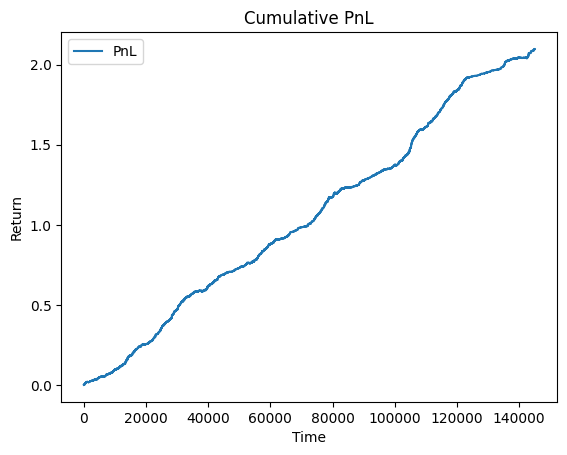

Sharpe Ratio for the epoch: 28.8593
Average Weights:



,Weight
Cash,8.175473e-01
BKNG,1.076035e-01
FICO,6.588265e-02
NVR,8.546310e-03
AZO,6.082055e-05
...,...
TEL,5.948248e-11
TGT,5.248425e-11
ALB,5.224713e-11
ROST,5.142972e-11


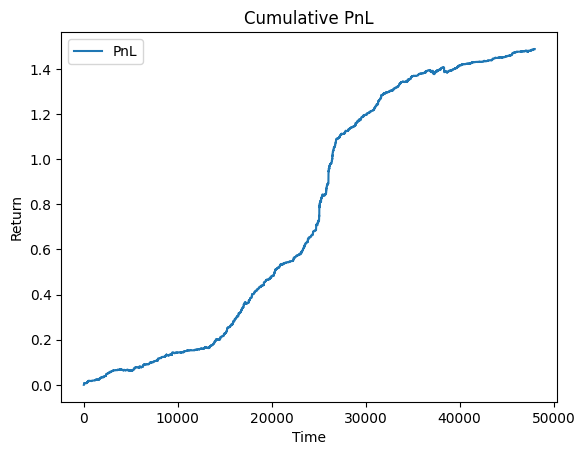

  2%|▏         | 23/1000 [19:09<13:18:06, 49.01s/it]

Sharpe Ratio for the epoch: 26.3898
Average Weights:



,Weight
Cash,7.551070e-01
BKNG,1.236134e-01
FICO,6.097750e-02
NVR,4.755812e-02
AZO,1.226242e-02
...,...
TEL,2.123616e-10
ALB,1.910537e-10
TGT,1.873622e-10
ROST,1.859819e-10


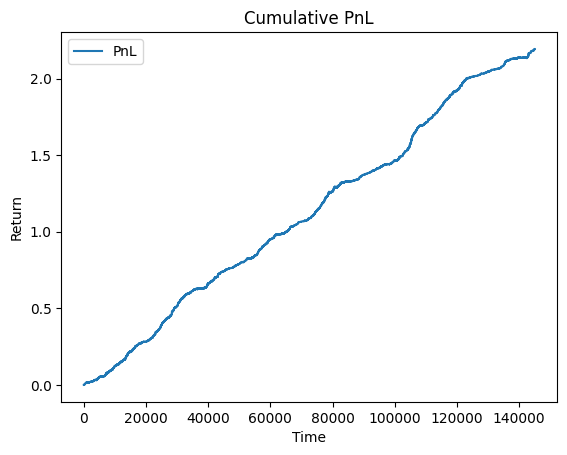

Sharpe Ratio for the epoch: 29.6384
Average Weights:



,Weight
Cash,8.025599e-01
BKNG,1.102065e-01
FICO,6.655418e-02
NVR,1.158404e-02
AZO,8.819310e-03
...,...
TEL,7.924026e-11
ALB,7.075581e-11
TGT,6.987946e-11
ROST,6.897759e-11


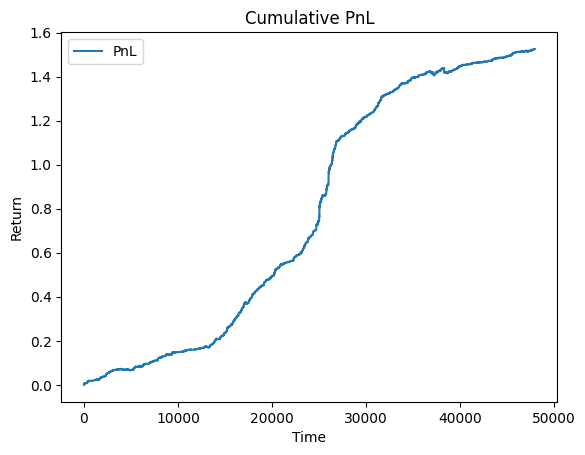

  2%|▏         | 24/1000 [19:59<13:18:05, 49.06s/it]

Sharpe Ratio for the epoch: 26.8925
Average Weights:



,Weight
Cash,7.389466e-01
BKNG,1.208931e-01
FICO,5.947233e-02
NVR,5.010181e-02
AZO,3.011076e-02
...,...
TEL,4.987037e-10
ALB,4.623822e-10
ROST,4.480596e-10
TGT,4.415033e-10


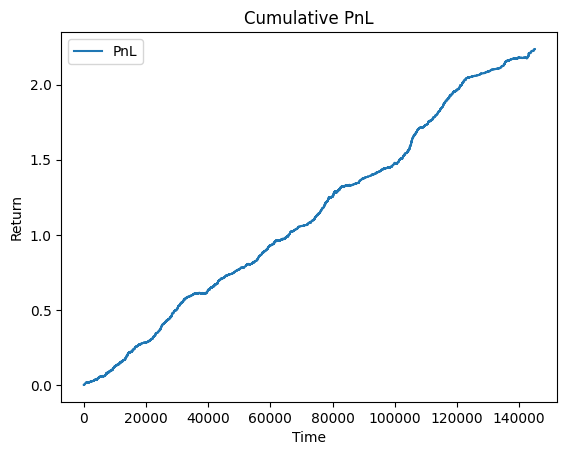

Sharpe Ratio for the epoch: 30.5574
Average Weights:



,Weight
Cash,7.736059e-01
BKNG,1.156541e-01
FICO,7.079766e-02
AZO,2.551625e-02
NVR,1.407075e-02
...,...
TEL,3.417833e-10
ALB,3.201265e-10
TGT,3.077319e-10
ROST,3.064292e-10


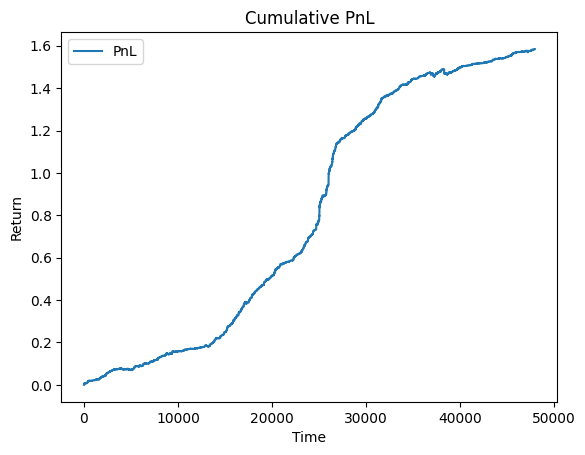

  2%|▎         | 25/1000 [20:49<13:23:17, 49.43s/it]

Sharpe Ratio for the epoch: 27.3553
Average Weights:



,Weight
Cash,7.299989e-01
BKNG,1.200976e-01
FICO,5.845003e-02
NVR,5.075458e-02
AZO,4.019163e-02
...,...
TEL,1.450680e-09
ALB,1.384248e-09
ROST,1.318895e-09
TGT,1.303923e-09


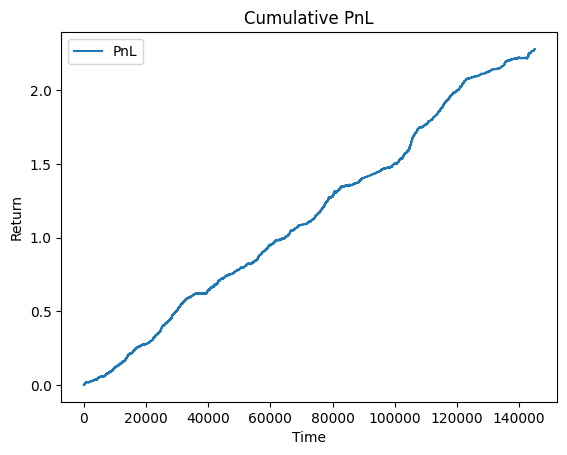

Sharpe Ratio for the epoch: 30.9406
Average Weights:



,Weight
Cash,7.597878e-01
BKNG,1.237239e-01
FICO,7.542453e-02
AZO,2.444295e-02
NVR,1.632724e-02
...,...
BEN,5.349236e-10
ALB,5.273341e-10
TGT,5.059259e-10
ROST,4.948503e-10


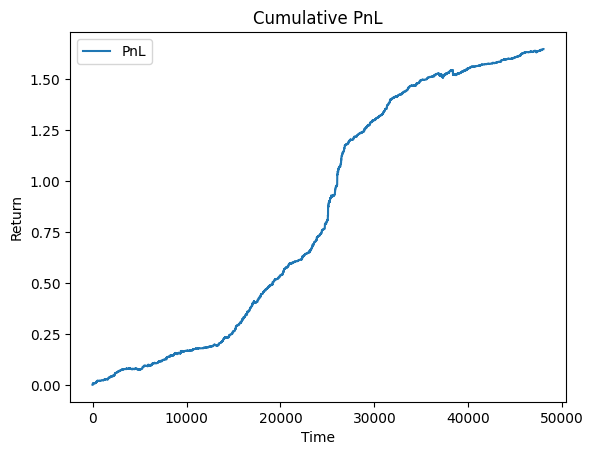

  3%|▎         | 26/1000 [21:38<13:21:54, 49.40s/it]

Sharpe Ratio for the epoch: 27.8009
Average Weights:



,Weight
Cash,7.258922e-01
BKNG,1.208617e-01
FICO,5.826517e-02
NVR,5.193659e-02
AZO,4.262743e-02
...,...
ALB,1.780946e-09
BEN,1.760444e-09
ROST,1.707410e-09
TGT,1.611706e-09


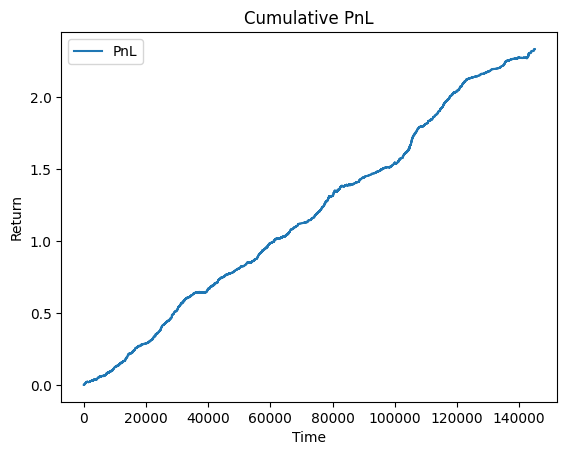

Sharpe Ratio for the epoch: 31.2045
Average Weights:



,Weight
Cash,7.544312e-01
BKNG,1.255357e-01
FICO,7.618145e-02
AZO,2.568133e-02
NVR,1.792302e-02
...,...
ALB,6.744294e-10
BEN,6.363878e-10
ROST,6.342999e-10
TGT,6.286471e-10


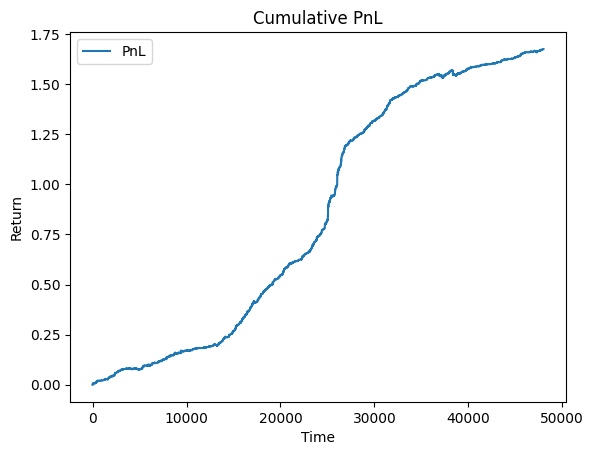

  3%|▎         | 27/1000 [22:27<13:19:02, 49.27s/it]

Sharpe Ratio for the epoch: 28.1435
Average Weights:



,Weight
Cash,7.228088e-01
BKNG,1.219141e-01
FICO,5.821054e-02
NVR,5.301576e-02
AZO,4.367467e-02
...,...
AMCR,2.700828e-09
ROST,2.642026e-09
TGT,2.478799e-09
BEN,2.449069e-09


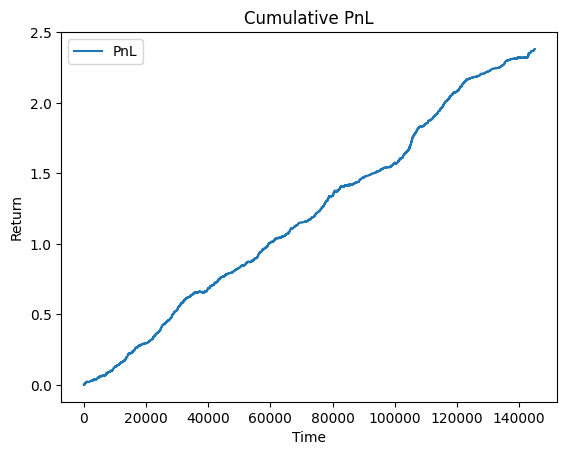

Sharpe Ratio for the epoch: 31.4300
Average Weights:



,Weight
Cash,7.534103e-01
BKNG,1.248154e-01
FICO,7.559945e-02
AZO,2.713609e-02
NVR,1.882938e-02
...,...
ROST,7.971629e-10
TGT,7.672762e-10
AMCR,7.445849e-10
BEN,7.113954e-10


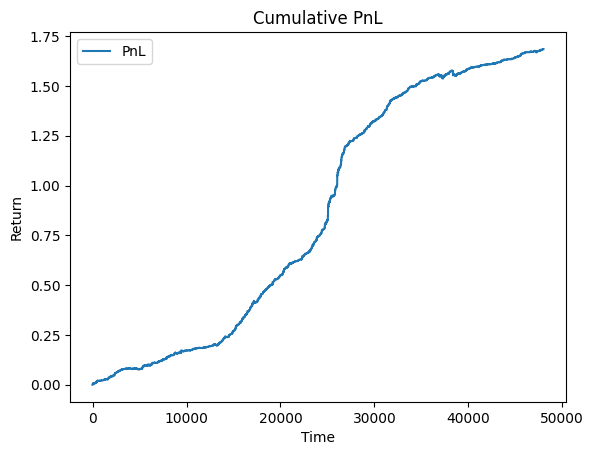

  3%|▎         | 28/1000 [23:16<13:16:55, 49.19s/it]

Sharpe Ratio for the epoch: 28.4192
Average Weights:



,Weight
Cash,7.203765e-01
BKNG,1.229528e-01
FICO,5.816701e-02
NVR,5.395944e-02
AZO,4.419441e-02
...,...
AAL,3.483783e-09
AES,3.412980e-09
BEN,3.096319e-09
DOW,2.987245e-09


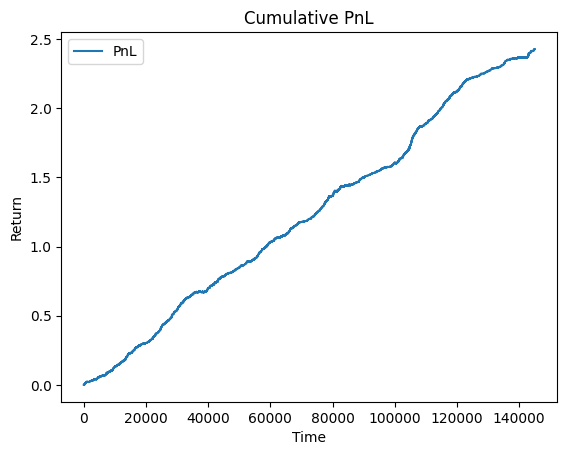

Sharpe Ratio for the epoch: 31.6423
Average Weights:



,Weight
Cash,7.534595e-01
BKNG,1.237486e-01
FICO,7.494062e-02
AZO,2.802460e-02
NVR,1.963099e-02
...,...
AES,9.651645e-10
AAL,9.436535e-10
DOW,8.956396e-10
BEN,8.760740e-10


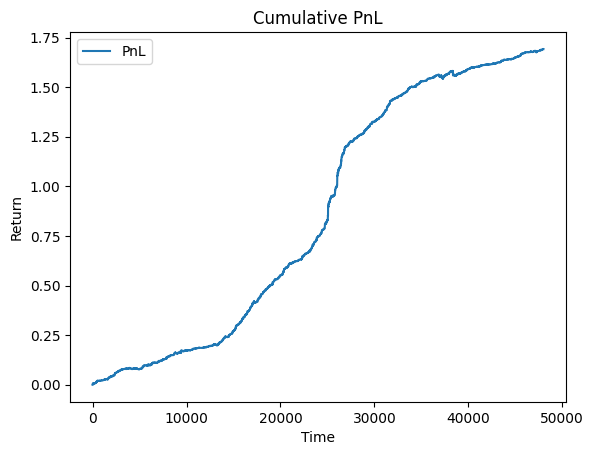

  3%|▎         | 29/1000 [24:05<13:15:02, 49.13s/it]

Sharpe Ratio for the epoch: 28.5379
Average Weights:



,Weight
Cash,7.170194e-01
BKNG,1.234174e-01
FICO,5.793406e-02
NVR,5.444835e-02
AZO,4.420344e-02
...,...
DOW,4.060342e-09
AES,3.869212e-09
AAL,3.815980e-09
BEN,3.795868e-09


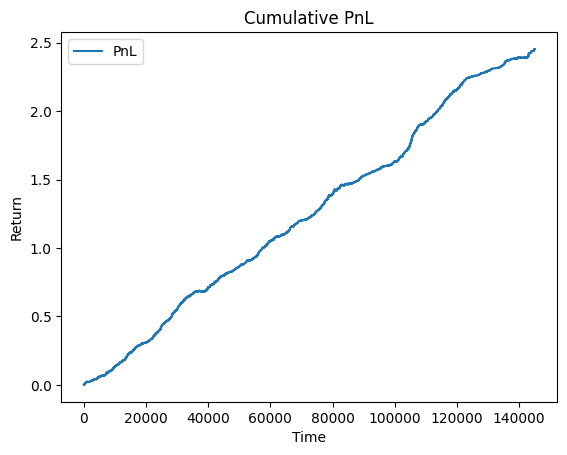

Sharpe Ratio for the epoch: 32.3294
Average Weights:



,Weight
Cash,7.186114e-01
BKNG,1.391236e-01
FICO,8.369965e-02
AZO,3.136047e-02
NVR,2.209620e-02
...,...
DOW,1.210665e-09
AES,1.084398e-09
BEN,1.058870e-09
AAL,1.027912e-09


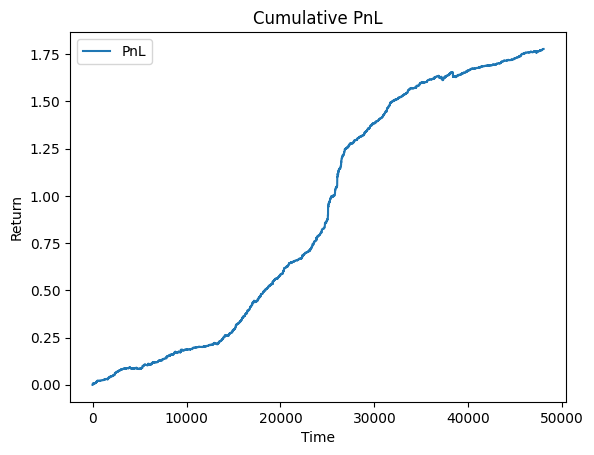

  3%|▎         | 30/1000 [24:54<13:12:24, 49.01s/it]

Sharpe Ratio for the epoch: 29.6301
Average Weights:



,Weight
Cash,7.185382e-01
BKNG,1.139124e-01
FICO,5.338058e-02
NVR,5.002759e-02
AZO,4.028882e-02
...,...
F,6.091192e-09
BEN,5.596343e-09
AES,5.336708e-09
AAL,5.062504e-09


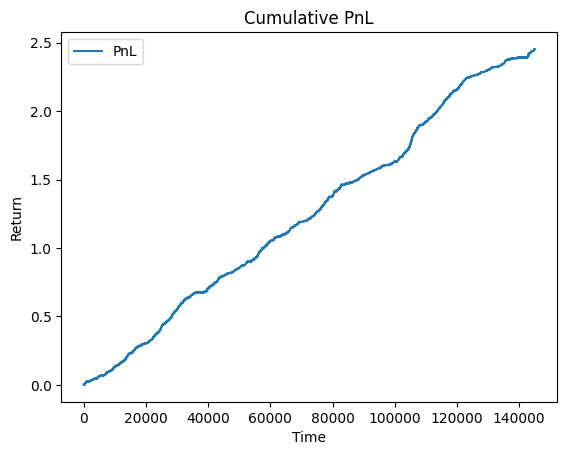

Sharpe Ratio for the epoch: 31.2446
Average Weights:



,Weight
Cash,7.213368e-01
BKNG,1.304572e-01
FICO,7.671297e-02
AZO,3.134305e-02
NVR,2.248070e-02
...,...
F,2.947018e-09
BEN,2.485831e-09
AES,2.466598e-09
AAL,2.200500e-09


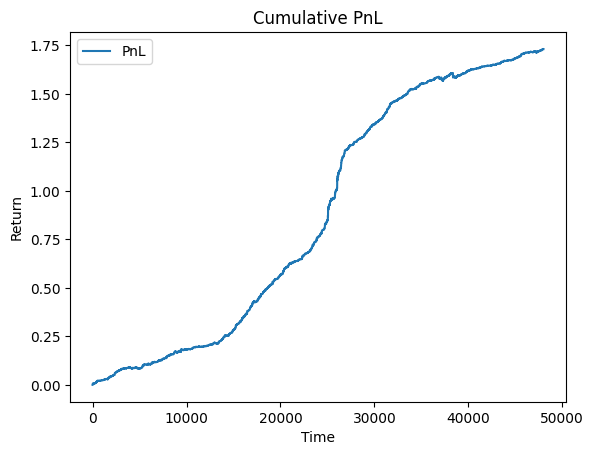

  3%|▎         | 31/1000 [25:43<13:12:31, 49.07s/it]

Sharpe Ratio for the epoch: 29.9991
Average Weights:



,Weight
Cash,7.178729e-01
BKNG,1.124661e-01
FICO,5.212700e-02
NVR,4.995002e-02
AZO,3.963679e-02
...,...
BEN,5.738833e-09
F,5.584521e-09
AES,5.073910e-09
AAL,4.752310e-09


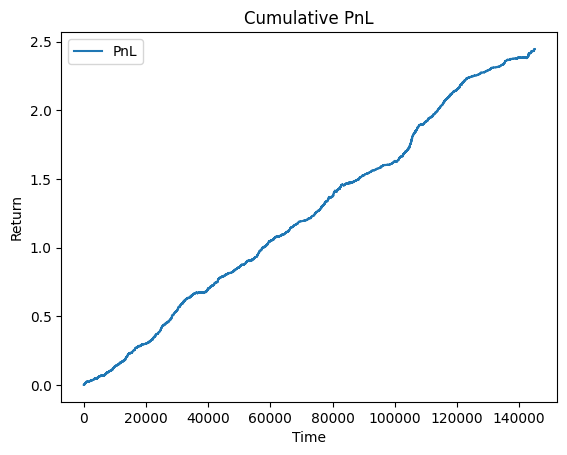

Sharpe Ratio for the epoch: 29.9917
Average Weights:



,Weight
Cash,7.115998e-01
BKNG,1.370786e-01
FICO,7.905885e-02
AZO,3.072852e-02
NVR,2.326516e-02
...,...
F,1.864936e-09
BEN,1.696826e-09
AES,1.617233e-09
AAL,1.411914e-09


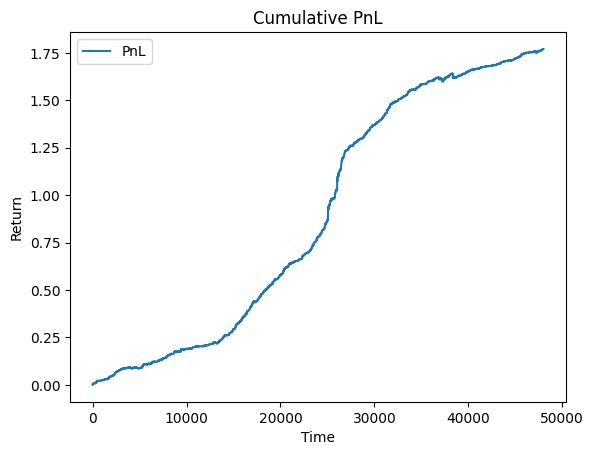

  3%|▎         | 32/1000 [26:32<13:11:32, 49.06s/it]

Sharpe Ratio for the epoch: 30.5349
Average Weights:



,Weight
Cash,7.145859e-01
BKNG,1.097854e-01
FICO,5.062789e-02
NVR,4.927387e-02
AZO,3.857791e-02
...,...
BEN,5.194432e-09
F,4.677610e-09
AES,4.456785e-09
AAL,4.074845e-09


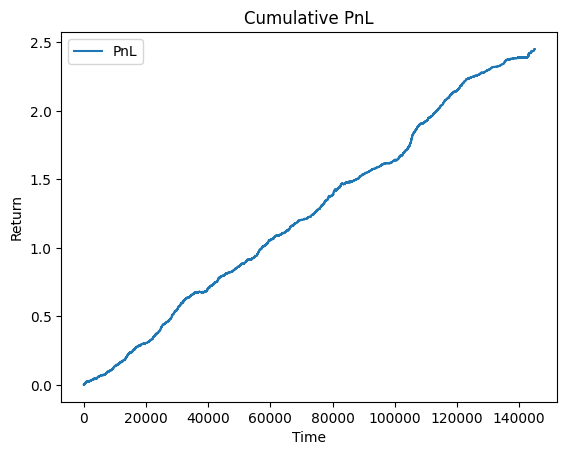

Sharpe Ratio for the epoch: 29.9432
Average Weights:



,Weight
Cash,7.106337e-01
BKNG,1.234606e-01
FICO,7.510865e-02
AZO,3.248380e-02
NVR,2.549490e-02
...,...
F,1.216899e-09
BEN,1.135217e-09
AES,9.835677e-10
AAL,8.975193e-10


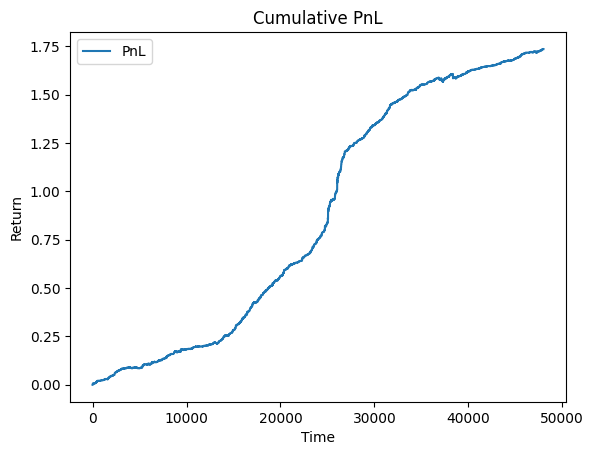

  3%|▎         | 33/1000 [27:21<13:10:15, 49.03s/it]

Sharpe Ratio for the epoch: 31.7796
Average Weights:



,Weight
Cash,7.218066e-01
BKNG,9.950029e-02
NVR,4.461839e-02
FICO,4.458936e-02
AZO,3.446658e-02
...,...
BEN,5.089426e-09
F,4.577198e-09
AES,4.285206e-09
AAL,3.902082e-09


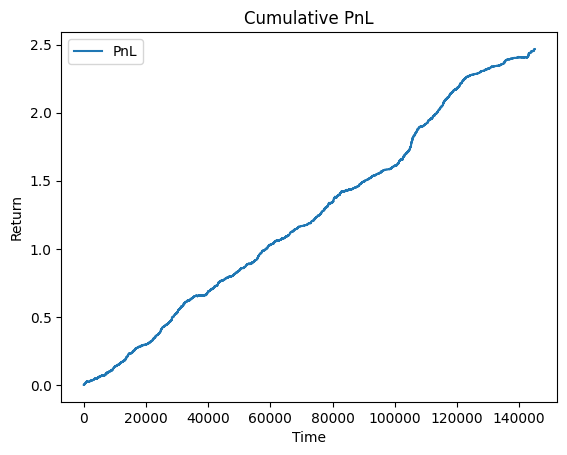

Sharpe Ratio for the epoch: 30.6782
Average Weights:



,Weight
Cash,7.254200e-01
BKNG,1.125324e-01
FICO,7.203910e-02
AZO,2.703949e-02
GWW,2.461319e-02
...,...
F,7.362364e-10
BEN,6.453209e-10
AES,6.154160e-10
AAL,5.107957e-10


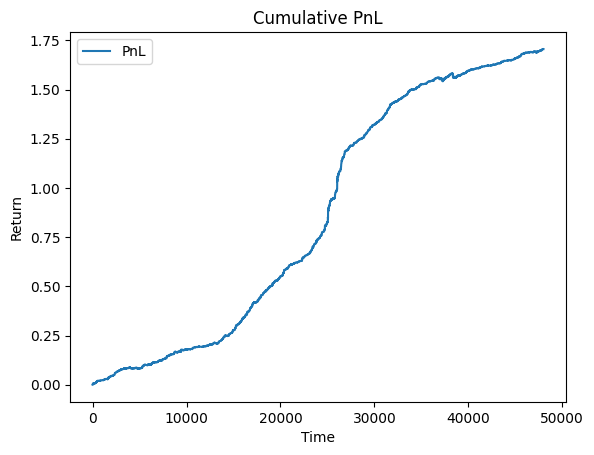

  3%|▎         | 34/1000 [28:10<13:09:32, 49.04s/it]

Sharpe Ratio for the epoch: 32.8249
Average Weights:



,Weight
Cash,7.150557e-01
BKNG,1.001922e-01
FICO,4.436594e-02
NVR,4.272204e-02
AZO,3.219235e-02
...,...
BEN,5.300832e-09
F,4.826768e-09
AES,4.490336e-09
AAL,4.116418e-09


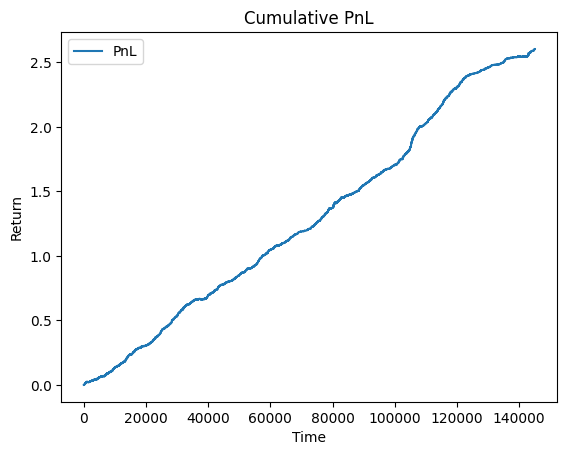

Sharpe Ratio for the epoch: 30.7156
Average Weights:



,Weight
Cash,7.441267e-01
BKNG,1.030529e-01
FICO,6.463407e-02
GWW,2.355379e-02
AZO,2.349892e-02
...,...
F,9.246143e-10
BEN,8.729364e-10
AES,8.478835e-10
AAL,6.843312e-10


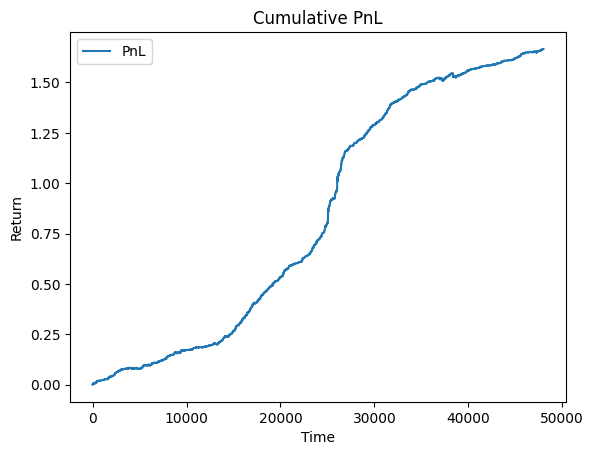

  4%|▎         | 35/1000 [28:59<13:09:15, 49.07s/it]

Sharpe Ratio for the epoch: 33.2999
Average Weights:



,Weight
Cash,7.119145e-01
BKNG,9.781177e-02
FICO,4.331834e-02
NVR,4.136414e-02
AZO,3.067704e-02
...,...
BEN,5.236962e-09
F,4.771091e-09
AES,4.573720e-09
AAL,3.980537e-09


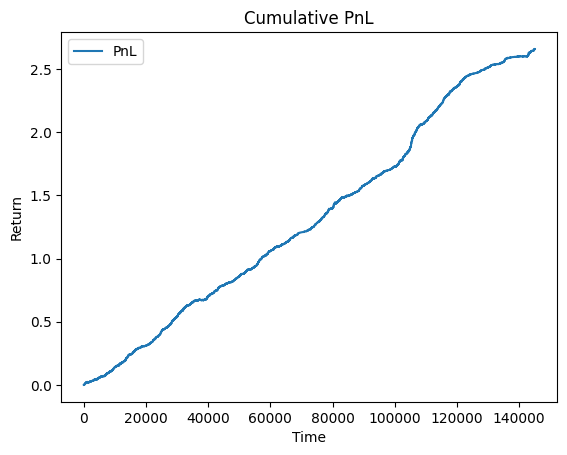

Sharpe Ratio for the epoch: 30.7083
Average Weights:



,Weight
Cash,7.536047e-01
BKNG,9.913656e-02
FICO,6.254628e-02
AZO,2.180674e-02
NVR,2.027788e-02
...,...
F,4.979614e-10
BEN,4.326282e-10
AES,4.022924e-10
AAL,3.441295e-10


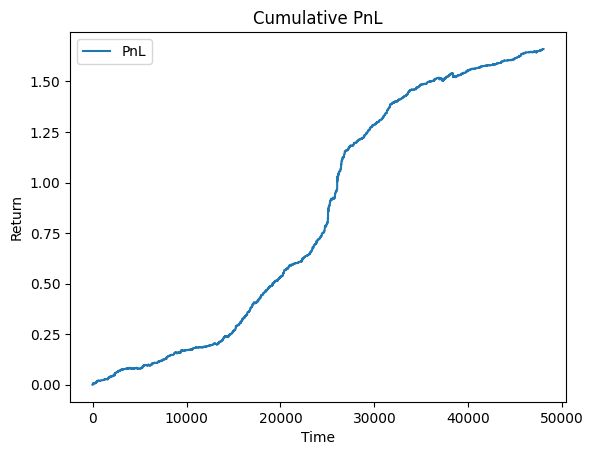

  4%|▎         | 36/1000 [29:48<13:07:39, 49.02s/it]

Sharpe Ratio for the epoch: 34.2946
Average Weights:



,Weight
Cash,7.103791e-01
BKNG,9.445294e-02
FICO,4.004949e-02
NVR,3.890552e-02
AZO,2.927900e-02
...,...
BEN,5.374923e-09
F,4.759811e-09
AES,4.555345e-09
AAL,4.037466e-09


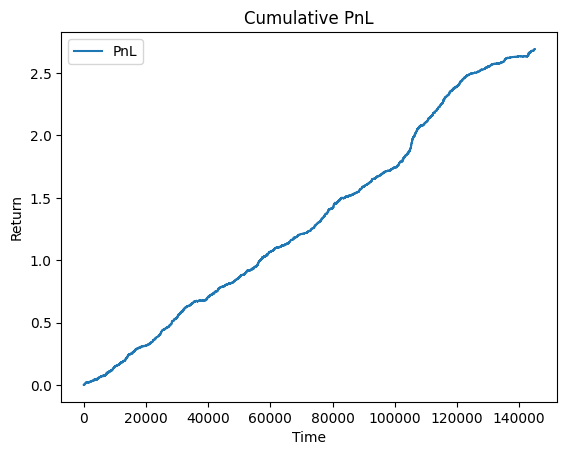

Sharpe Ratio for the epoch: 31.4071
Average Weights:



,Weight
Cash,7.416773e-01
BKNG,1.075062e-01
FICO,5.885153e-02
AZO,2.261160e-02
NVR,2.210775e-02
...,...
F,5.516767e-10
BEN,4.763385e-10
AES,4.519086e-10
AAL,3.741568e-10


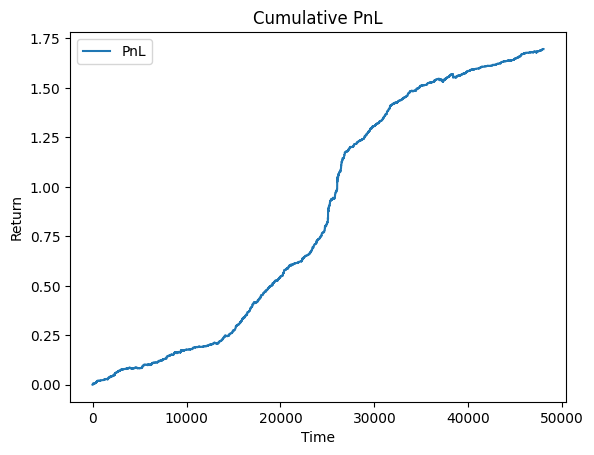

  4%|▎         | 37/1000 [30:37<13:06:48, 49.02s/it]

Sharpe Ratio for the epoch: 34.6624
Average Weights:



,Weight
Cash,7.093884e-01
BKNG,9.368315e-02
FICO,3.975231e-02
NVR,3.916097e-02
AZO,2.834843e-02
...,...
BEN,4.213939e-09
F,3.768862e-09
AES,3.570178e-09
AAL,3.141454e-09


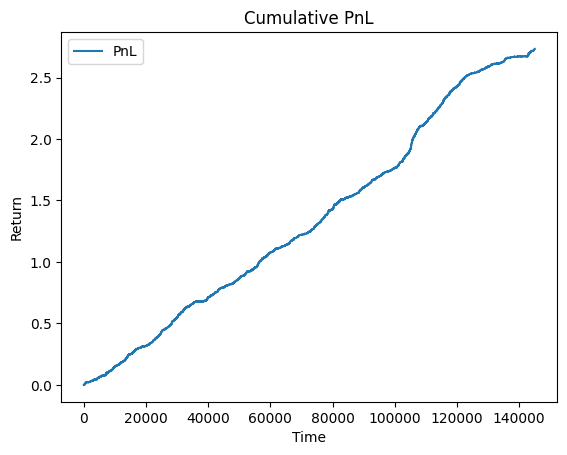

Sharpe Ratio for the epoch: 32.0032
Average Weights:



,Weight
Cash,7.332723e-01
BKNG,1.077427e-01
FICO,5.859298e-02
NVR,2.296345e-02
AZO,2.254787e-02
...,...
F,9.739810e-10
BEN,8.792928e-10
AES,8.639957e-10
AAL,6.985594e-10


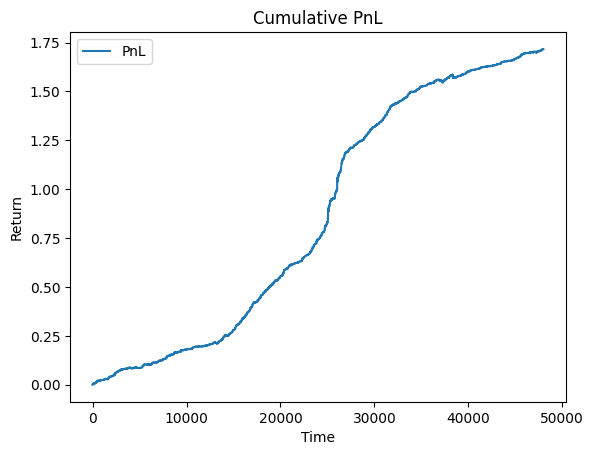

  4%|▍         | 38/1000 [31:26<13:05:22, 48.98s/it]

Sharpe Ratio for the epoch: 34.9712
Average Weights:



,Weight
Cash,7.076030e-01
BKNG,9.321927e-02
FICO,3.937165e-02
NVR,3.930835e-02
AZO,2.771735e-02
...,...
BEN,3.375535e-09
F,3.088188e-09
AES,2.872197e-09
AAL,2.518263e-09


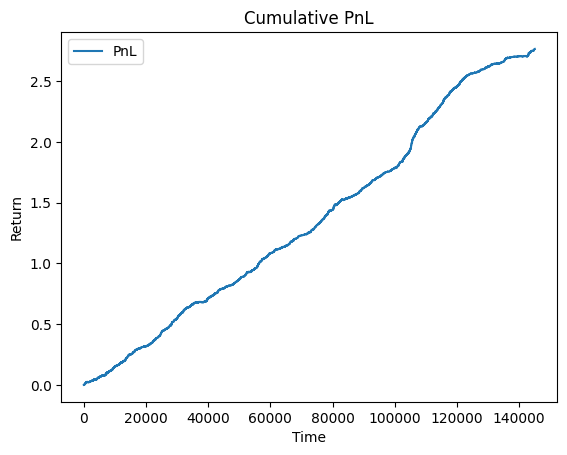

Sharpe Ratio for the epoch: 33.3135
Average Weights:



,Weight
Cash,7.257103e-01
BKNG,1.045950e-01
FICO,5.701266e-02
AZO,2.444701e-02
NVR,2.327399e-02
...,...
F,1.845164e-09
AES,1.778241e-09
BEN,1.771182e-09
AAL,1.432166e-09


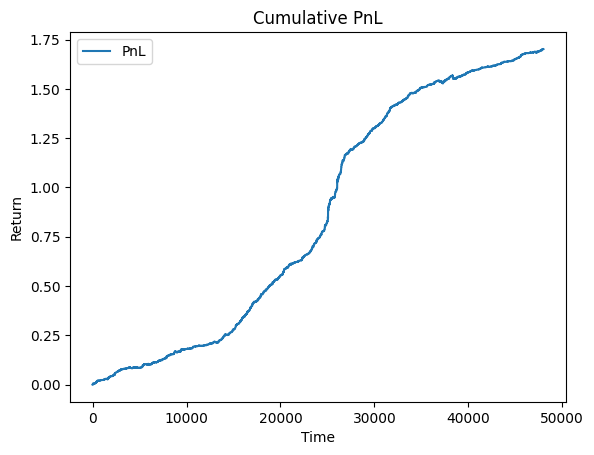

  4%|▍         | 39/1000 [32:15<13:04:24, 48.97s/it]

Sharpe Ratio for the epoch: 35.2088
Average Weights:



,Weight
Cash,7.059312e-01
BKNG,9.269065e-02
NVR,3.950949e-02
FICO,3.914957e-02
AZO,2.722369e-02
...,...
BEN,2.730261e-09
F,2.517757e-09
AES,2.338254e-09
AAL,2.059796e-09


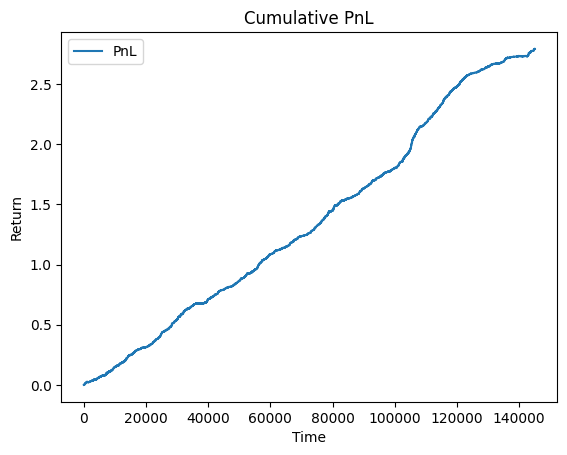

Sharpe Ratio for the epoch: 34.5823
Average Weights:



,Weight
Cash,7.198367e-01
BKNG,1.011087e-01
FICO,5.414606e-02
GWW,2.620917e-02
AZO,2.528422e-02
...,...
F,2.008323e-09
BEN,1.910821e-09
AES,1.843678e-09
AAL,1.544421e-09


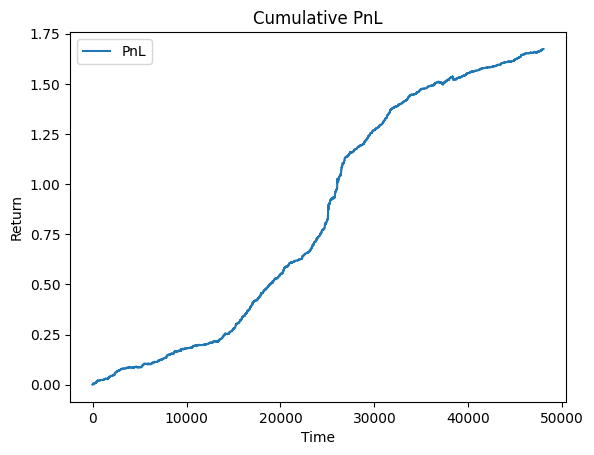

  4%|▍         | 40/1000 [33:04<13:03:57, 49.00s/it]

Sharpe Ratio for the epoch: 35.4699
Average Weights:



,Weight
Cash,7.038451e-01
BKNG,9.201811e-02
NVR,3.969640e-02
FICO,3.880189e-02
TDG,2.742840e-02
...,...
WBA,3.381159e-09
F,3.029004e-09
AES,2.915914e-09
AAL,2.587029e-09


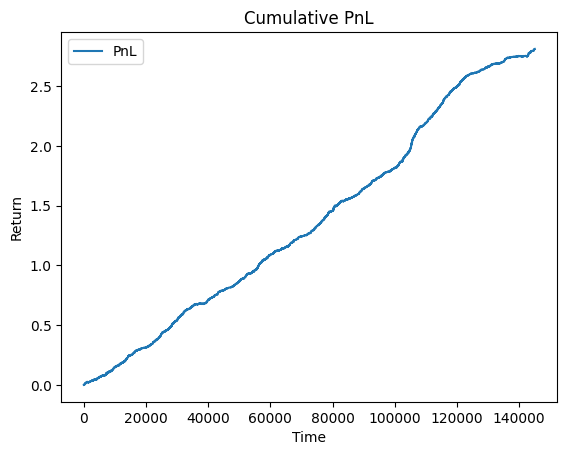

Sharpe Ratio for the epoch: 32.7529
Average Weights:



,Weight
Cash,7.084506e-01
BKNG,9.502858e-02
FICO,5.216601e-02
GWW,3.177008e-02
AZO,2.577441e-02
...,...
F,2.595937e-09
BEN,2.516321e-09
AES,2.363141e-09
AAL,2.007791e-09


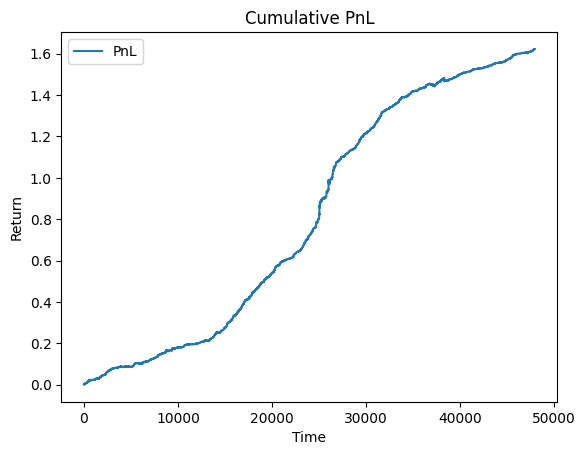

  4%|▍         | 41/1000 [33:53<13:03:33, 49.02s/it]

Sharpe Ratio for the epoch: 35.5981
Average Weights:



,Weight
Cash,7.020671e-01
BKNG,9.175409e-02
NVR,4.014594e-02
FICO,3.863970e-02
TDG,2.766531e-02
...,...
WBA,2.638852e-09
F,2.441569e-09
AES,2.278535e-09
AAL,2.053328e-09


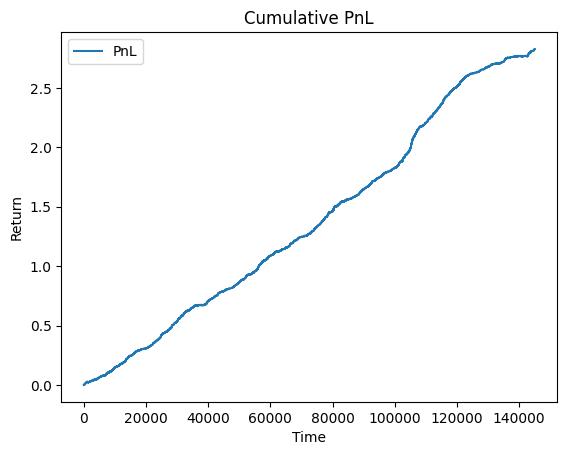

Sharpe Ratio for the epoch: 33.5099
Average Weights:



,Weight
Cash,6.974487e-01
BKNG,9.128007e-02
FICO,4.879205e-02
GWW,3.530979e-02
AZO,3.048288e-02
...,...
BEN,4.398433e-09
AES,4.207161e-09
F,4.184570e-09
AAL,3.580458e-09


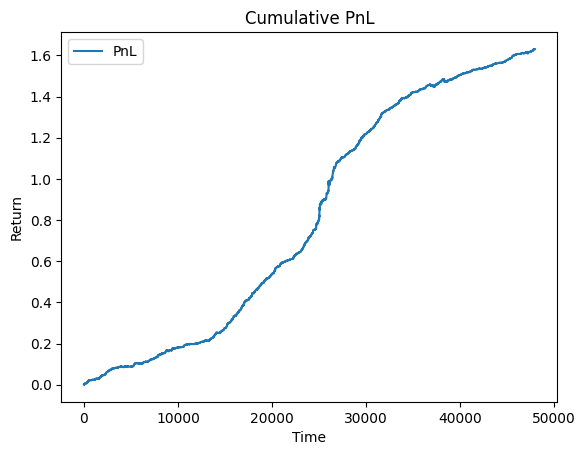

  4%|▍         | 42/1000 [34:42<13:01:54, 48.97s/it]

Sharpe Ratio for the epoch: 35.7719
Average Weights:



,Weight
Cash,6.996586e-01
BKNG,9.098865e-02
NVR,4.048188e-02
FICO,3.822704e-02
TDG,2.827324e-02
...,...
WBA,2.905798e-09
F,2.697179e-09
AES,2.561137e-09
AAL,2.316564e-09


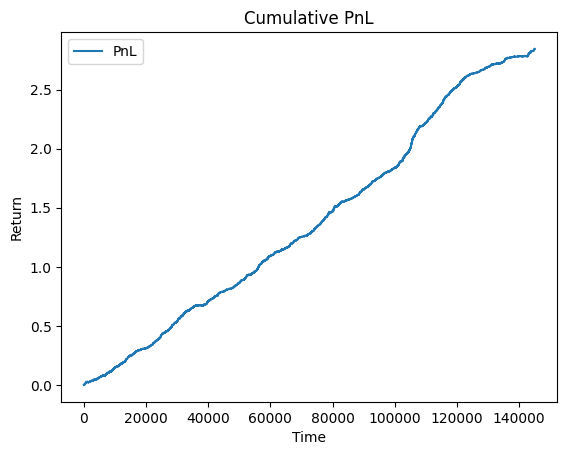

Sharpe Ratio for the epoch: 33.6499
Average Weights:



,Weight
Cash,6.834232e-01
BKNG,8.657699e-02
FICO,4.838848e-02
GWW,3.925964e-02
AZO,3.283109e-02
...,...
WBA,6.373226e-09
AES,6.093023e-09
F,5.765299e-09
AAL,5.256164e-09


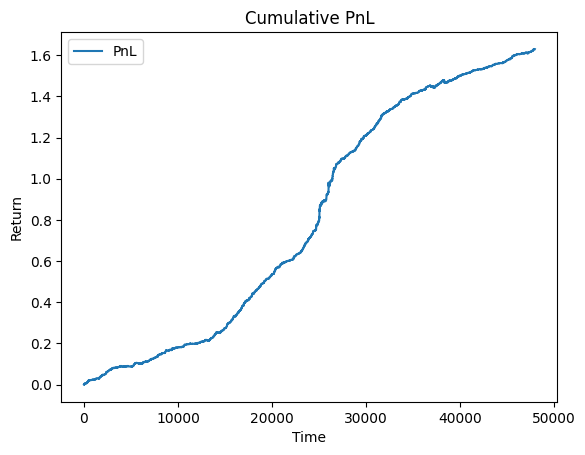

  4%|▍         | 43/1000 [35:31<13:00:40, 48.94s/it]

Sharpe Ratio for the epoch: 35.9289
Average Weights:



,Weight
Cash,6.967620e-01
BKNG,9.017757e-02
NVR,4.077258e-02
FICO,3.796669e-02
TDG,2.876635e-02
...,...
WBA,2.920925e-09
F,2.725993e-09
AES,2.617045e-09
AAL,2.398519e-09


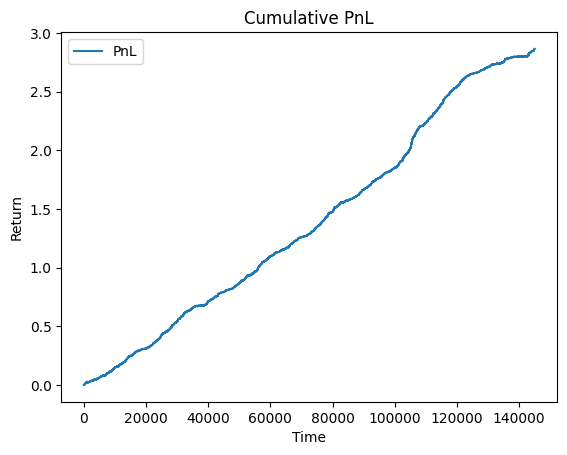

Sharpe Ratio for the epoch: 32.6972
Average Weights:



,Weight
Cash,6.573710e-01
BKNG,8.257902e-02
FICO,4.659721e-02
GWW,4.464990e-02
AZO,3.624283e-02
...,...
WBA,8.924991e-09
AES,8.590397e-09
F,8.156892e-09
AAL,7.671081e-09


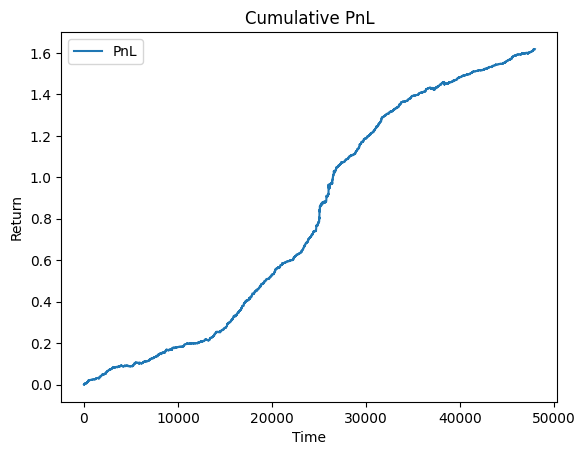

  4%|▍         | 44/1000 [36:20<13:00:33, 48.99s/it]

Sharpe Ratio for the epoch: 36.1266
Average Weights:



,Weight
Cash,6.950225e-01
BKNG,8.929960e-02
NVR,4.117356e-02
FICO,3.766578e-02
TDG,2.911690e-02
...,...
WBA,2.588984e-09
F,2.462715e-09
AES,2.326722e-09
AAL,2.197674e-09


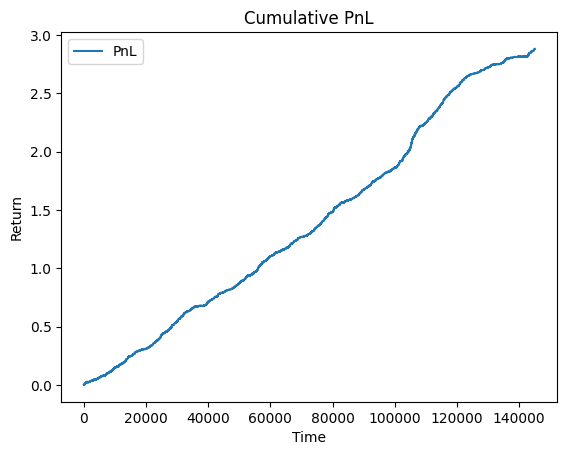

Sharpe Ratio for the epoch: 33.2846
Average Weights:



,Weight
Cash,6.437498e-01
BKNG,7.824595e-02
GWW,5.065693e-02
FICO,4.613064e-02
AZO,3.939668e-02
...,...
WBA,9.776069e-09
AES,9.442570e-09
F,9.072975e-09
AAL,8.741791e-09


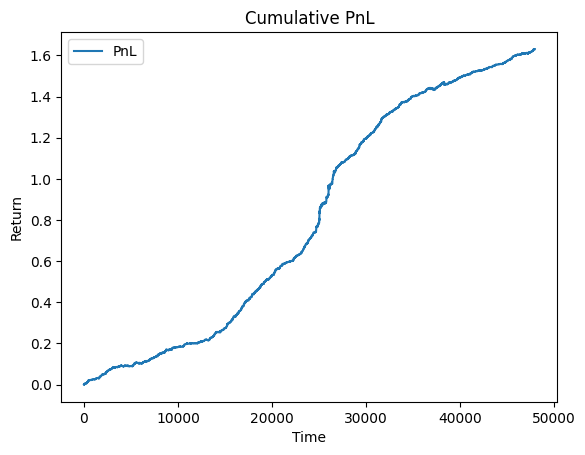

  4%|▍         | 45/1000 [37:09<13:00:30, 49.04s/it]

Sharpe Ratio for the epoch: 36.2657
Average Weights:



,Weight
Cash,6.934704e-01
BKNG,8.840732e-02
NVR,4.131254e-02
FICO,3.751203e-02
TDG,2.946451e-02
...,...
WBA,2.482071e-09
F,2.379137e-09
AES,2.238969e-09
AAL,2.162496e-09


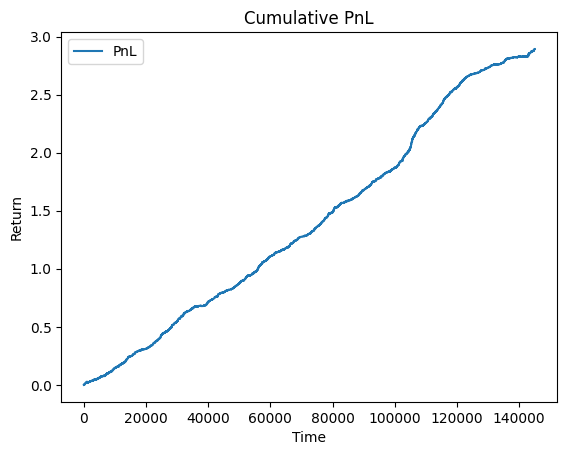

Sharpe Ratio for the epoch: 33.5408
Average Weights:



,Weight
Cash,6.326230e-01
BKNG,7.344503e-02
GWW,5.575494e-02
FICO,4.670941e-02
AZO,4.240553e-02
...,...
WBA,1.118472e-08
AES,1.091942e-08
F,1.036341e-08
AAL,1.034144e-08


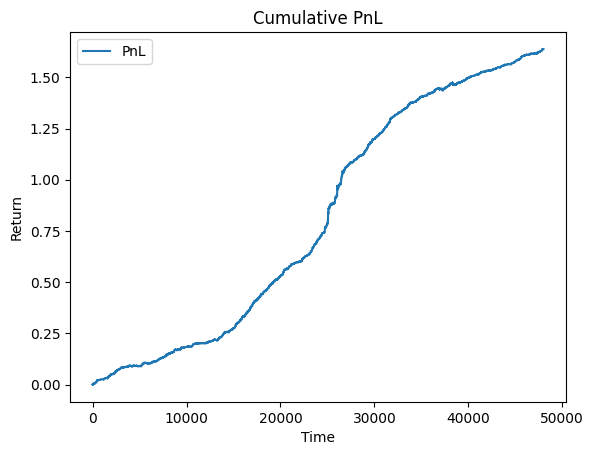

  5%|▍         | 46/1000 [37:58<12:59:05, 49.00s/it]

Sharpe Ratio for the epoch: 36.3826
Average Weights:



,Weight
Cash,6.925424e-01
BKNG,8.767436e-02
NVR,4.147126e-02
FICO,3.764184e-02
TDG,2.978203e-02
...,...
WBA,2.318465e-09
F,2.232204e-09
AES,2.085548e-09
AAL,2.066229e-09


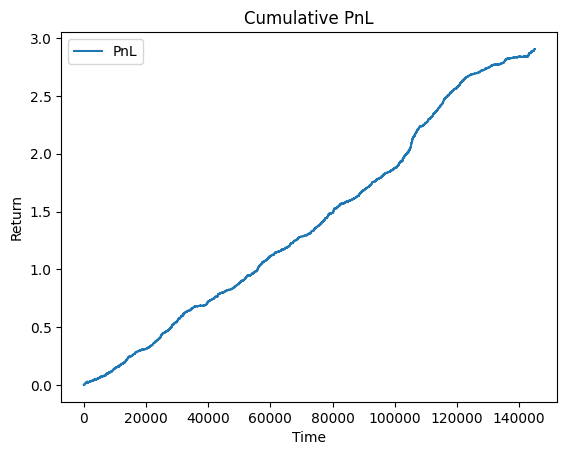

Sharpe Ratio for the epoch: 33.6002
Average Weights:



,Weight
Cash,6.279927e-01
BKNG,6.860607e-02
GWW,6.123758e-02
FICO,4.773771e-02
AZO,4.528449e-02
...,...
WBA,1.347989e-08
AES,1.335249e-08
AAL,1.314092e-08
F,1.245616e-08


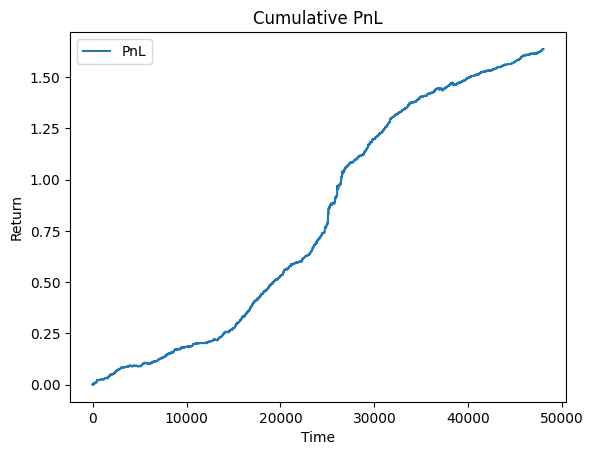

  5%|▍         | 47/1000 [38:47<12:58:28, 49.01s/it]

Sharpe Ratio for the epoch: 36.4423
Average Weights:



,Weight
Cash,6.921369e-01
BKNG,8.730482e-02
NVR,4.139636e-02
FICO,3.813485e-02
TDG,2.993014e-02
...,...
WBA,1.920623e-09
F,1.856349e-09
AAL,1.726105e-09
AES,1.680633e-09


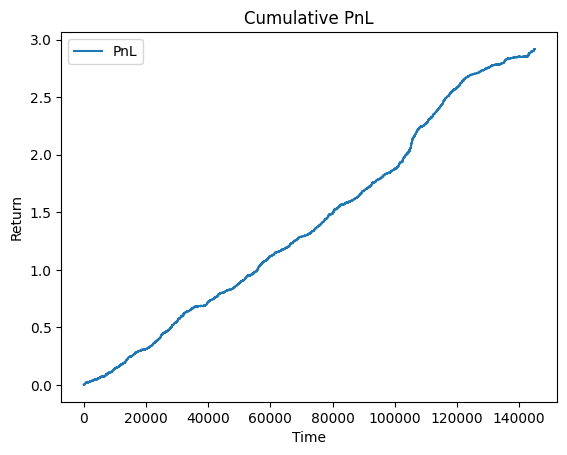

Sharpe Ratio for the epoch: 34.0641
Average Weights:



,Weight
Cash,6.344528e-01
GWW,6.622952e-02
BKNG,6.492765e-02
FICO,5.082988e-02
AZO,4.644010e-02
...,...
WBA,1.056267e-08
AAL,1.041031e-08
AES,9.899352e-09
F,9.811050e-09


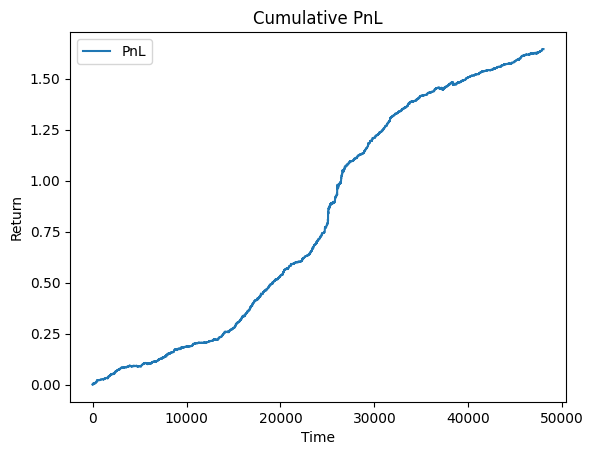

  5%|▍         | 48/1000 [39:36<12:58:43, 49.08s/it]

Sharpe Ratio for the epoch: 36.5348
Average Weights:



,Weight
Cash,6.914660e-01
BKNG,8.684774e-02
NVR,4.125298e-02
FICO,3.822868e-02
TDG,3.000207e-02
...,...
WBA,1.867222e-09
F,1.761234e-09
AAL,1.647709e-09
AES,1.579570e-09


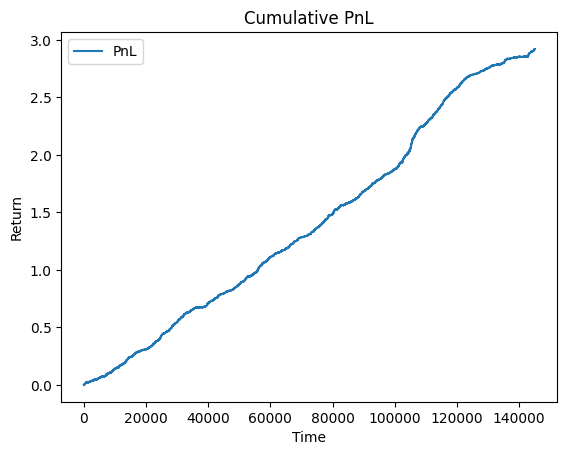

Sharpe Ratio for the epoch: 31.5260
Average Weights:



,Weight
Cash,6.359631e-01
BKNG,6.375308e-02
GWW,6.270672e-02
FICO,5.357606e-02
AZO,4.839938e-02
...,...
WBA,8.567049e-09
AAL,8.399328e-09
AES,7.854734e-09
F,7.848340e-09


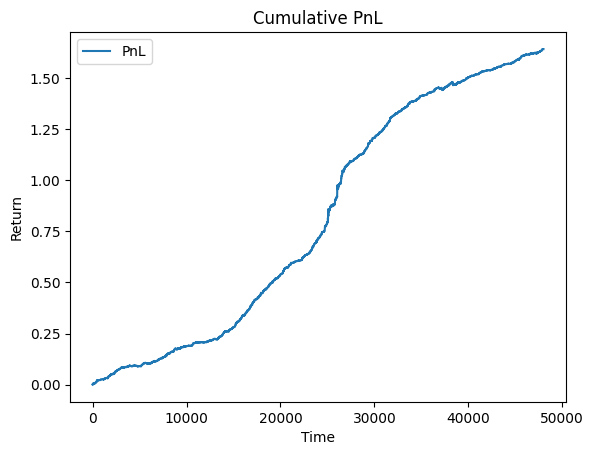

  5%|▍         | 49/1000 [40:26<12:59:12, 49.16s/it]

Sharpe Ratio for the epoch: 36.5524
Average Weights:



,Weight
Cash,6.896729e-01
BKNG,8.640603e-02
NVR,4.073832e-02
FICO,3.808659e-02
TDG,2.972706e-02
...,...
WBA,1.963536e-09
F,1.779503e-09
AAL,1.669883e-09
AES,1.595310e-09


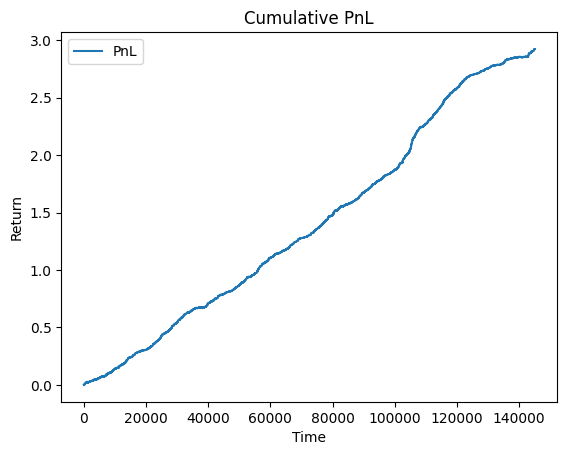

Sharpe Ratio for the epoch: 26.5082
Average Weights:



,Weight
Cash,6.286035e-01
GWW,6.155753e-02
BKNG,6.125171e-02
FICO,5.231158e-02
AZO,4.583085e-02
...,...
WBA,8.564635e-09
AAL,8.485238e-09
AES,8.103945e-09
F,7.527806e-09


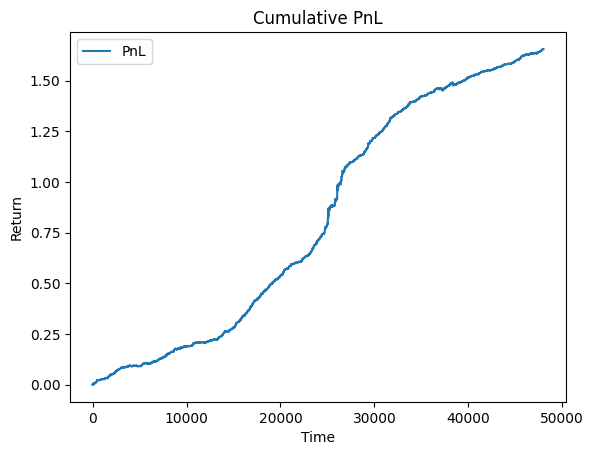

  5%|▌         | 50/1000 [41:15<12:57:37, 49.11s/it]

Sharpe Ratio for the epoch: 36.6279
Average Weights:



,Weight
Cash,6.883856e-01
BKNG,8.642036e-02
NVR,4.081125e-02
FICO,3.793842e-02
TDG,2.970742e-02
...,...
BEN,1.888633e-09
F,1.687185e-09
AAL,1.591066e-09
AES,1.534006e-09


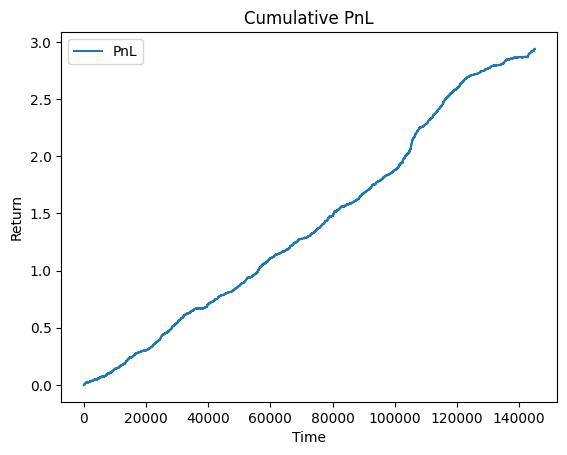

Sharpe Ratio for the epoch: 27.3193
Average Weights:



,Weight
Cash,6.270817e-01
BKNG,6.283461e-02
GWW,5.562213e-02
FICO,5.014683e-02
AZO,4.406300e-02
...,...
WBA,6.715839e-09
AAL,6.272879e-09
AES,5.953806e-09
F,5.599253e-09


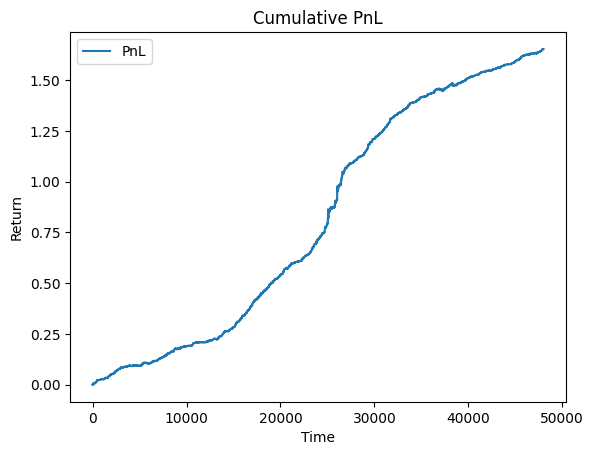

  5%|▌         | 51/1000 [42:04<12:56:51, 49.12s/it]

Sharpe Ratio for the epoch: 36.7289
Average Weights:



,Weight
Cash,6.873373e-01
BKNG,8.623255e-02
NVR,4.068510e-02
FICO,3.801563e-02
TDG,2.914880e-02
...,...
BEN,1.797950e-09
F,1.554625e-09
AAL,1.474476e-09
AES,1.427445e-09


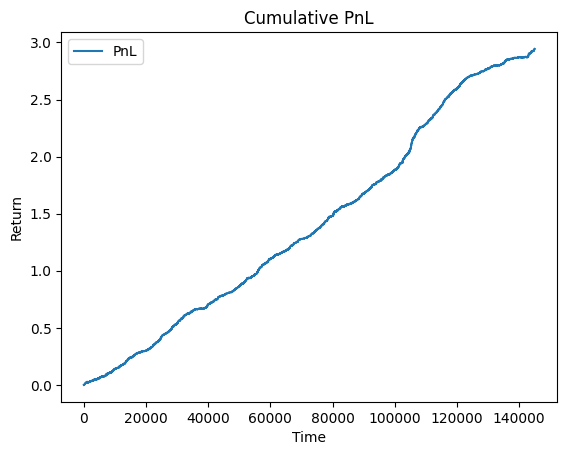

Sharpe Ratio for the epoch: 26.7681
Average Weights:



,Weight
Cash,6.285066e-01
BKNG,6.239822e-02
GWW,5.764705e-02
FICO,5.165567e-02
AZO,4.341498e-02
...,...
WBA,7.315406e-09
AAL,6.476260e-09
AES,5.977106e-09
F,5.975444e-09


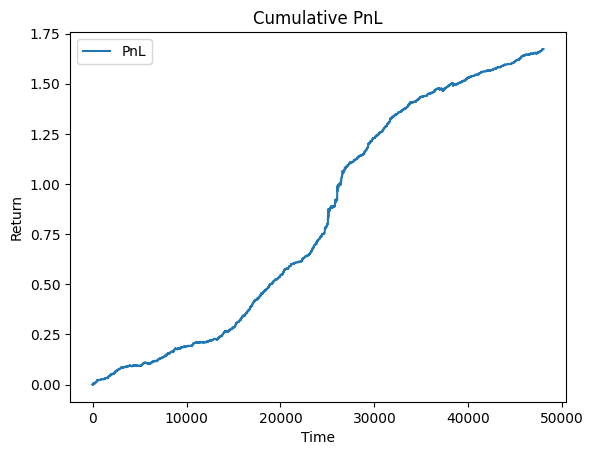

  5%|▌         | 52/1000 [42:53<12:55:02, 49.05s/it]

Sharpe Ratio for the epoch: 36.7849
Average Weights:



,Weight
Cash,6.866049e-01
BKNG,8.618101e-02
NVR,4.069215e-02
FICO,3.800353e-02
TDG,2.968879e-02
...,...
BEN,1.727940e-09
F,1.523286e-09
AAL,1.417289e-09
AES,1.370783e-09


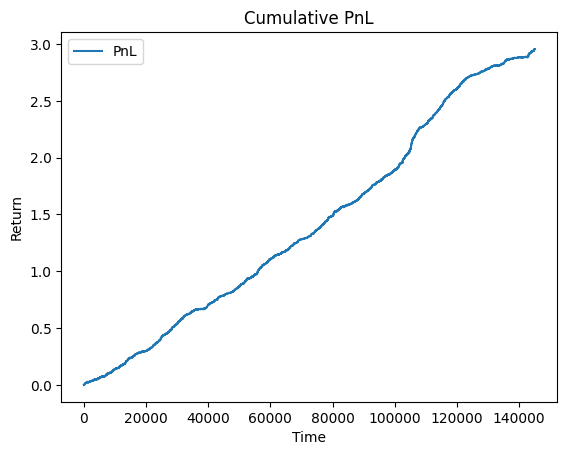

Sharpe Ratio for the epoch: 27.4223
Average Weights:



,Weight
Cash,6.278568e-01
BKNG,6.312848e-02
GWW,5.325361e-02
FICO,5.276428e-02
AZO,4.700062e-02
...,...
CCL,5.138329e-09
AAL,4.447790e-09
AES,4.197531e-09
F,4.099328e-09


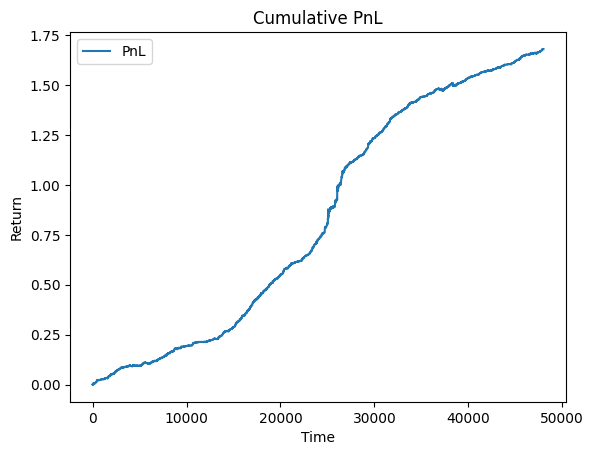

  5%|▌         | 53/1000 [43:42<12:54:25, 49.07s/it]

Sharpe Ratio for the epoch: 36.8652
Average Weights:



,Weight
Cash,6.860863e-01
BKNG,8.628342e-02
NVR,4.095333e-02
FICO,3.786060e-02
AZO,2.964164e-02
...,...
BEN,1.683931e-09
F,1.466461e-09
AAL,1.344404e-09
AES,1.312952e-09


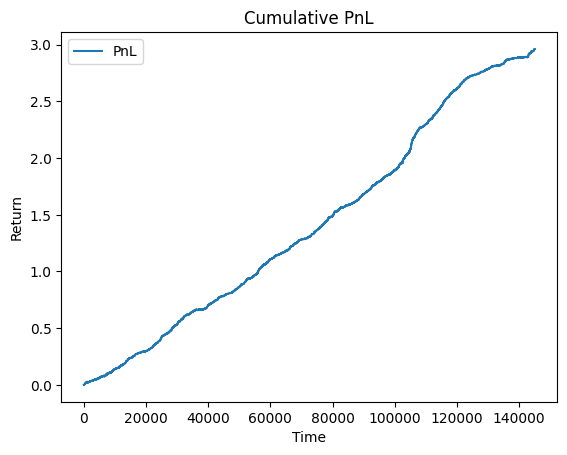

Sharpe Ratio for the epoch: 27.9997
Average Weights:



,Weight
Cash,6.299480e-01
BKNG,6.335527e-02
FICO,5.404276e-02
GWW,5.339189e-02
AZO,4.607908e-02
...,...
CCL,3.391889e-09
AAL,2.933543e-09
AES,2.857853e-09
F,2.678896e-09


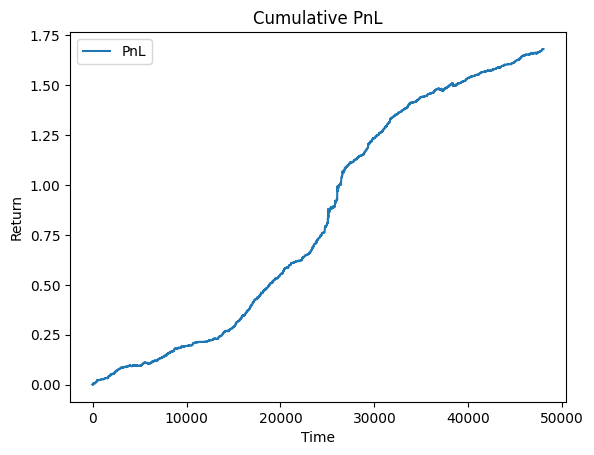

  5%|▌         | 54/1000 [44:31<12:53:09, 49.04s/it]

Sharpe Ratio for the epoch: 36.9335
Average Weights:



,Weight
Cash,6.850534e-01
BKNG,8.580423e-02
NVR,4.085020e-02
FICO,3.810772e-02
AZO,2.972395e-02
...,...
CCL,1.377564e-09
F,1.173467e-09
AAL,1.085572e-09
AES,1.080040e-09


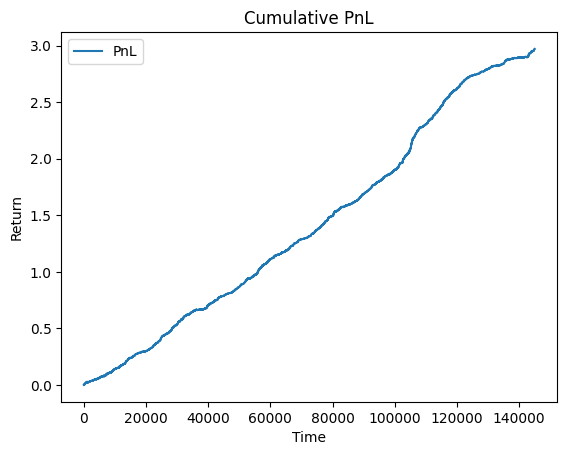

Sharpe Ratio for the epoch: 27.3044
Average Weights:



,Weight
Cash,6.276816e-01
BKNG,6.252698e-02
FICO,5.400443e-02
GWW,5.369886e-02
AZO,4.708645e-02
...,...
CCL,6.810698e-09
AAL,5.951649e-09
AES,5.825644e-09
F,5.568164e-09


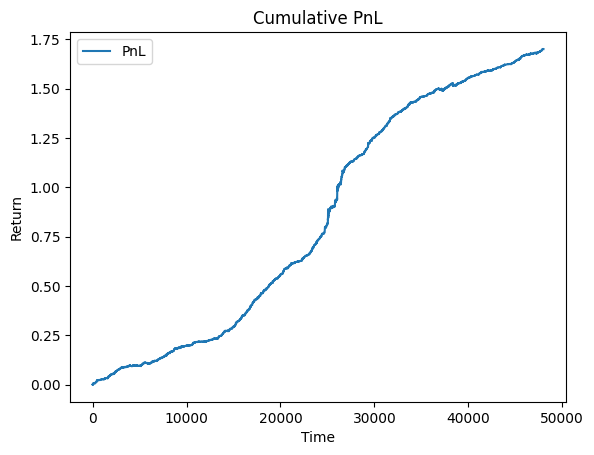

  6%|▌         | 55/1000 [45:23<13:06:57, 49.97s/it]

Sharpe Ratio for the epoch: 37.1050
Average Weights:



,Weight
Cash,6.847824e-01
BKNG,8.512702e-02
NVR,4.154367e-02
FICO,3.814173e-02
AZO,3.011572e-02
...,...
CCL,1.729594e-09
F,1.466760e-09
AAL,1.374746e-09
AES,1.368080e-09


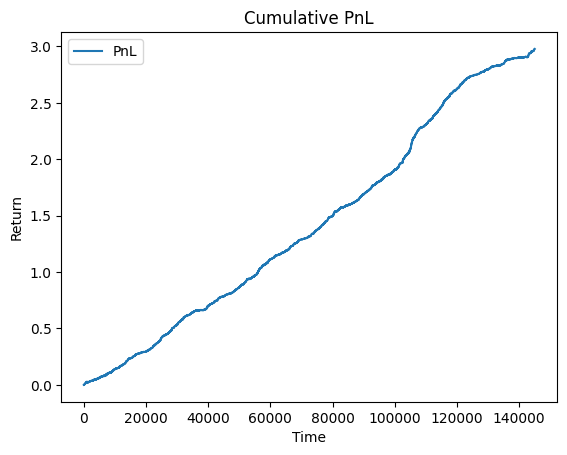

Sharpe Ratio for the epoch: 26.4836
Average Weights:



,Weight
Cash,6.339853e-01
BKNG,6.186721e-02
GWW,5.844229e-02
FICO,5.603701e-02
AZO,4.729019e-02
...,...
CCL,6.851726e-09
AAL,6.110416e-09
AES,5.837339e-09
F,5.801968e-09


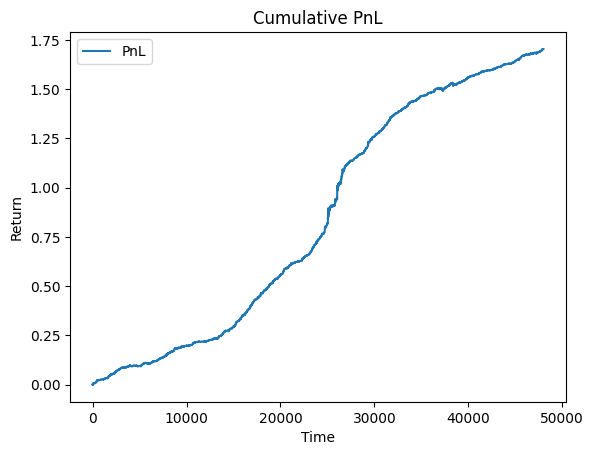

  6%|▌         | 56/1000 [46:17<13:27:18, 51.31s/it]

Sharpe Ratio for the epoch: 37.1354
Average Weights:



,Weight
Cash,6.836765e-01
BKNG,8.492160e-02
NVR,4.080949e-02
FICO,3.840614e-02
TDG,3.050328e-02
...,...
CCL,1.727157e-09
F,1.508739e-09
AAL,1.395732e-09
AES,1.384860e-09


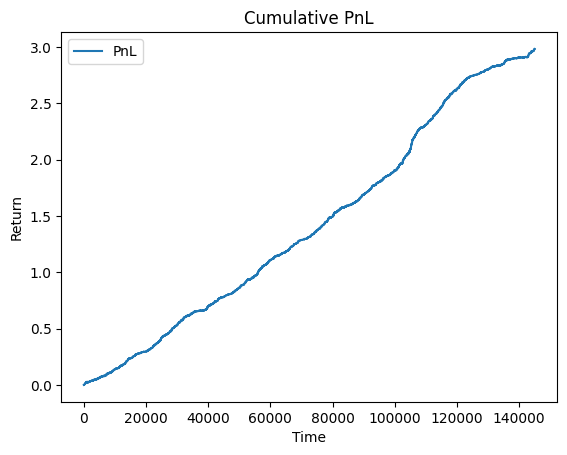

Sharpe Ratio for the epoch: 26.4261
Average Weights:



,Weight
Cash,6.317351e-01
BKNG,5.905469e-02
FICO,5.905083e-02
GWW,5.832410e-02
AZO,5.049292e-02
...,...
CCL,3.857191e-09
AAL,3.484198e-09
AES,3.296428e-09
F,3.275106e-09


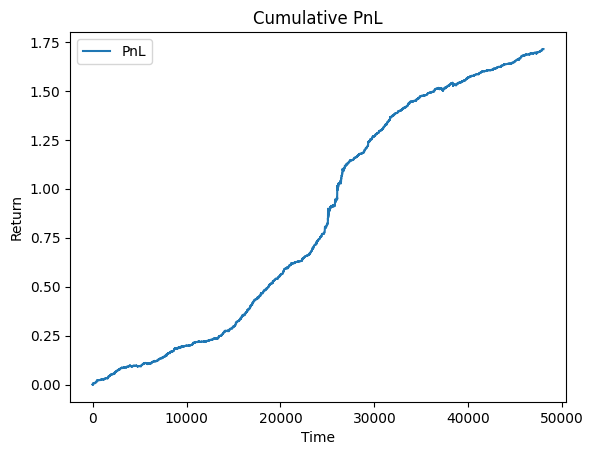

  6%|▌         | 57/1000 [47:10<13:32:51, 51.72s/it]

Sharpe Ratio for the epoch: 37.1717
Average Weights:



,Weight
Cash,6.832506e-01
BKNG,8.478163e-02
NVR,4.118180e-02
FICO,3.817045e-02
TDG,3.096349e-02
...,...
CCL,1.399112e-09
F,1.247213e-09
AAL,1.145043e-09
AES,1.127556e-09


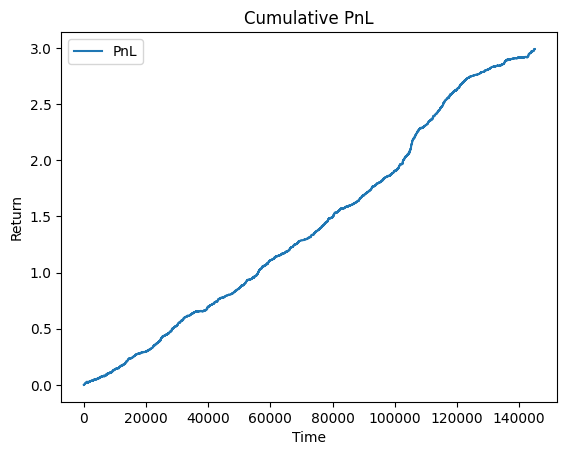

Sharpe Ratio for the epoch: 27.1250
Average Weights:



,Weight
Cash,6.320760e-01
BKNG,6.028283e-02
FICO,5.908992e-02
GWW,5.641298e-02
AZO,5.181104e-02
...,...
CCL,2.022488e-09
AAL,1.824910e-09
AES,1.806337e-09
F,1.748041e-09


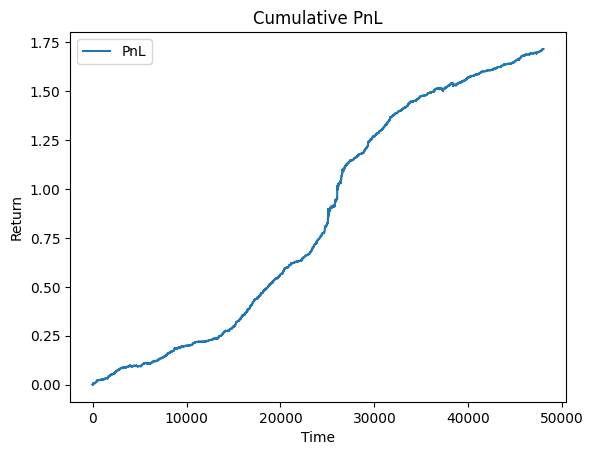

  6%|▌         | 58/1000 [48:07<13:57:51, 53.37s/it]

Sharpe Ratio for the epoch: 37.1481
Average Weights:



,Weight
Cash,6.822409e-01
BKNG,8.511347e-02
NVR,4.089857e-02
FICO,3.821786e-02
AZO,3.035204e-02
...,...
CCL,1.078607e-09
F,9.773554e-10
AES,8.882399e-10
AAL,8.829716e-10


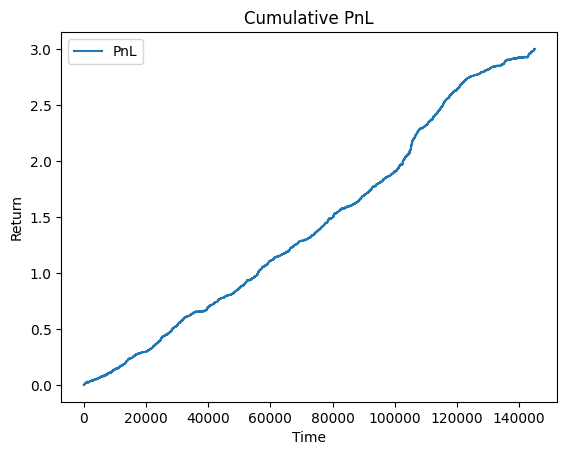

Sharpe Ratio for the epoch: 28.0726
Average Weights:



,Weight
Cash,6.296074e-01
BKNG,6.248325e-02
FICO,5.933736e-02
GWW,5.153660e-02
AZO,5.108272e-02
...,...
CCL,1.203755e-09
AES,1.109622e-09
F,1.093148e-09
AAL,1.086339e-09


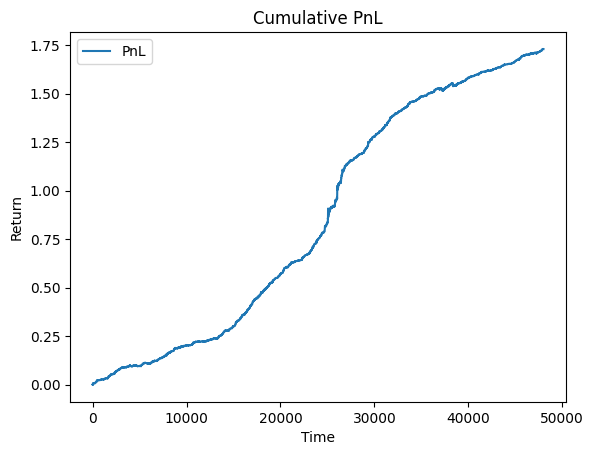

  6%|▌         | 59/1000 [49:02<14:04:11, 53.83s/it]

Sharpe Ratio for the epoch: 37.2157
Average Weights:



,Weight
Cash,6.813576e-01
BKNG,8.537035e-02
NVR,4.117592e-02
FICO,3.807279e-02
AZO,3.082217e-02
...,...
CCL,9.250587e-10
F,8.566512e-10
AES,7.794192e-10
AAL,7.559182e-10


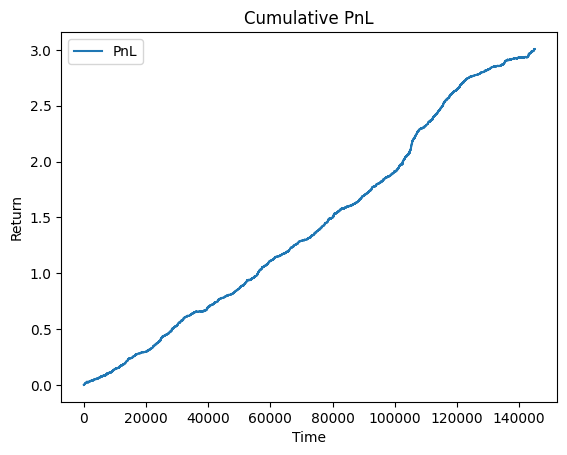

Sharpe Ratio for the epoch: 28.7446
Average Weights:



,Weight
Cash,6.314690e-01
BKNG,6.495882e-02
FICO,5.930747e-02
GWW,4.867694e-02
AZO,4.849316e-02
...,...
CCL,1.090345e-09
F,1.014583e-09
AAL,9.886972e-10
AES,9.870559e-10


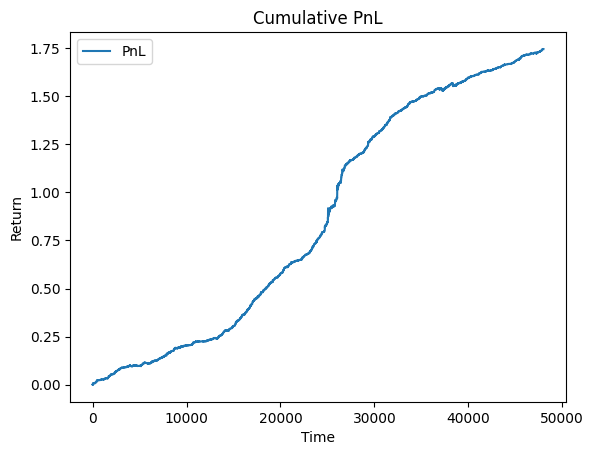

  6%|▌         | 60/1000 [49:54<13:53:14, 53.19s/it]

Sharpe Ratio for the epoch: 37.2780
Average Weights:



,Weight
Cash,6.806033e-01
BKNG,8.529615e-02
NVR,4.120884e-02
FICO,3.816686e-02
AZO,3.107799e-02
...,...
CCL,8.617151e-10
F,8.099082e-10
AES,7.324529e-10
AAL,7.078600e-10


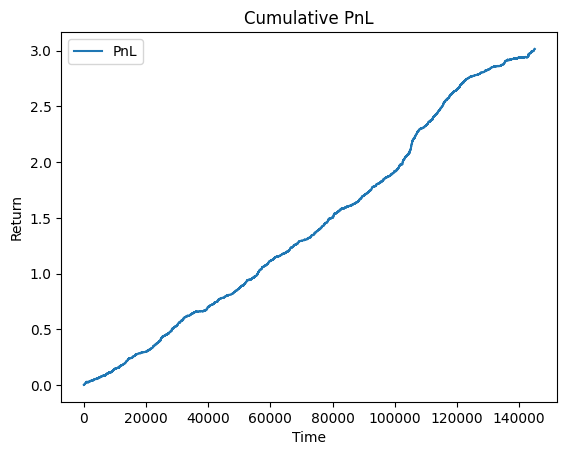

Sharpe Ratio for the epoch: 28.8519
Average Weights:



,Weight
Cash,6.317867e-01
BKNG,6.603294e-02
FICO,6.089399e-02
AZO,4.692194e-02
GWW,4.619836e-02
...,...
CCL,1.444532e-09
AAL,1.319627e-09
F,1.311430e-09
AES,1.278522e-09


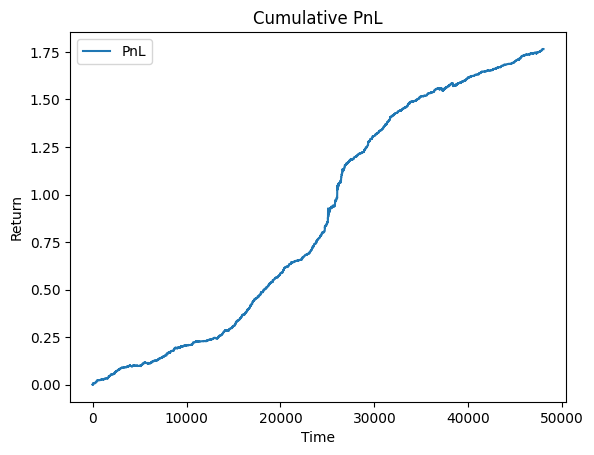

  6%|▌         | 61/1000 [50:46<13:47:22, 52.87s/it]

Sharpe Ratio for the epoch: 37.3296
Average Weights:



,Weight
Cash,6.802002e-01
BKNG,8.511899e-02
NVR,4.149020e-02
FICO,3.805064e-02
AZO,3.114110e-02
...,...
CCL,9.827940e-10
F,9.190624e-10
AES,8.256567e-10
AAL,8.163903e-10


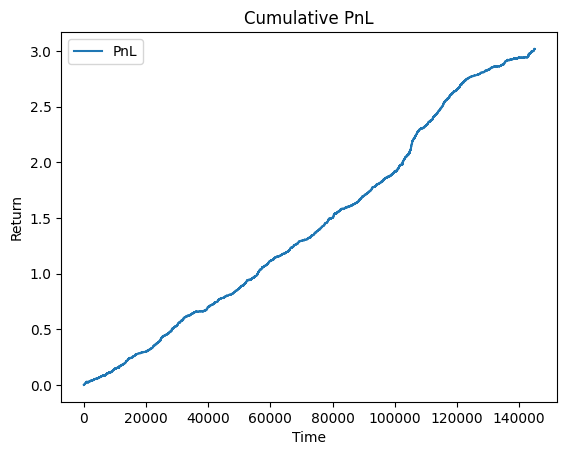

Sharpe Ratio for the epoch: 28.8400
Average Weights:



,Weight
Cash,6.306779e-01
BKNG,6.468091e-02
FICO,6.307965e-02
GWW,4.761168e-02
AZO,4.685022e-02
...,...
CCL,1.312013e-09
AAL,1.216803e-09
AES,1.198012e-09
F,1.180858e-09


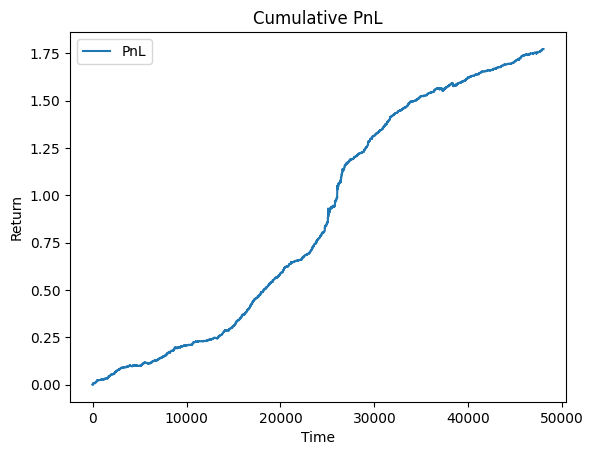

  6%|▌         | 62/1000 [51:43<14:07:09, 54.19s/it]

Sharpe Ratio for the epoch: 37.3958
Average Weights:



,Weight
Cash,6.801367e-01
BKNG,8.493619e-02
NVR,4.145850e-02
FICO,3.787623e-02
AZO,3.108816e-02
...,...
CCL,1.063379e-09
F,9.804215e-10
AES,8.980765e-10
AAL,8.899792e-10


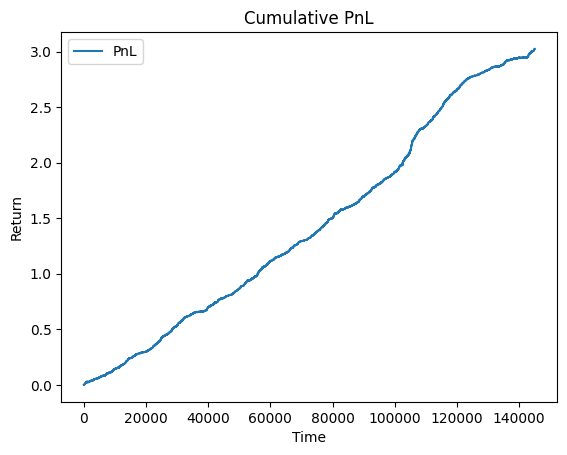

Sharpe Ratio for the epoch: 29.2615
Average Weights:



,Weight
Cash,6.314490e-01
FICO,6.557564e-02
BKNG,6.498878e-02
GWW,4.931751e-02
AZO,4.777426e-02
...,...
CCL,6.574003e-10
F,6.240420e-10
AES,6.171279e-10
AAL,6.144754e-10


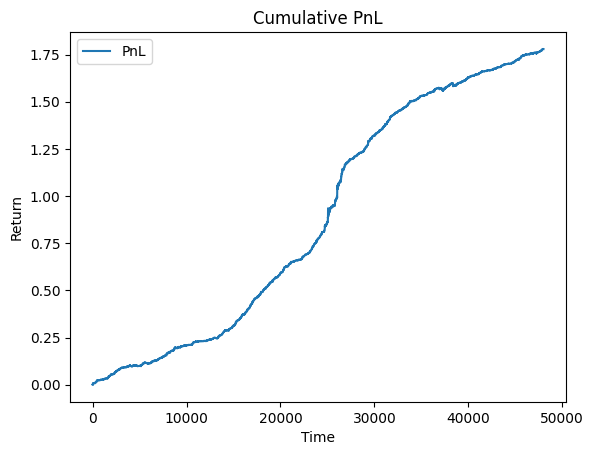

  6%|▋         | 63/1000 [52:43<14:33:48, 55.95s/it]

Sharpe Ratio for the epoch: 37.4478
Average Weights:



,Weight
Cash,6.799710e-01
BKNG,8.488873e-02
NVR,4.142726e-02
FICO,3.769325e-02
AZO,3.128800e-02
...,...
CCL,8.889627e-10
F,8.323489e-10
AES,7.644849e-10
AAL,7.428771e-10


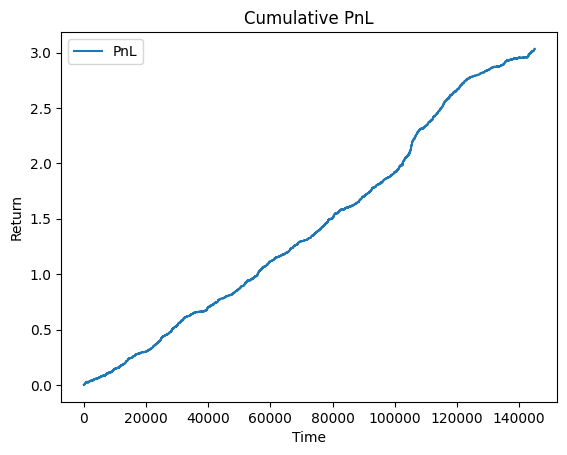

Sharpe Ratio for the epoch: 29.9788
Average Weights:



,Weight
Cash,6.309509e-01
BKNG,6.821028e-02
FICO,6.737288e-02
AZO,4.758957e-02
GWW,4.601189e-02
...,...
CCL,5.442637e-10
F,5.251993e-10
AAL,5.056756e-10
AES,5.024120e-10


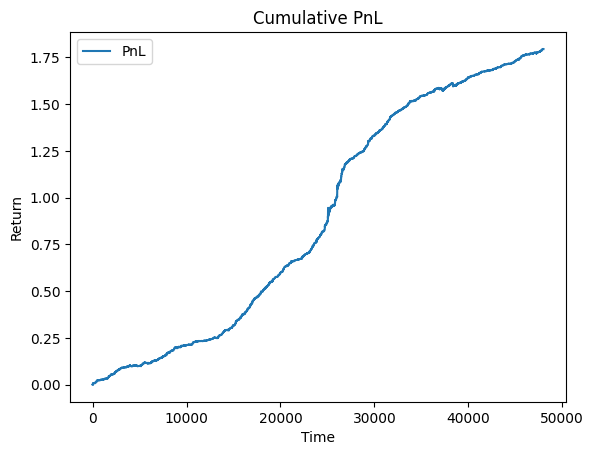

  6%|▋         | 64/1000 [53:43<14:49:48, 57.04s/it]

In [ ]:
batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

model = DeepPortfolioAllocator_1(
    cmf_dim=cmf_dim,
    num_assets=num_assets,
)

optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs)):
    if epoch in batch_size_config:
        print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
        batch_size = batch_size_config[epoch]
        pipeline = FeaturesPipeline(
            path_to_data,
            padding=padding,
            batch_size=batch_size,
            split_dates=split_dates,
            split_names=split_names
        )

    loss_fn = StreamingSharpeLoss(
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)  # (T, n_assets)
        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)

        if len(common_feats) != batch_size  :
            continue

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()